In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
from scipy.stats import skew, sem, t
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,roc_auc_score
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
import warnings
import pickle

# Technical Challenge – Credit Risk & Product Propensity Modeling 

#### Goals
- **Credit Risk Model:** Identify clients unlikely to fulfill contractual conditions.  
- **Propensity Model:** Predict probability of contracting Product 2.  
- **Fairness Audit:** Evaluate models decisions for disparate impact across protected groups.  
- **Temporal Drift Analysis:** Assess performance stability over time and detect distribution shifts.

## Dataset Overview

#### We are provided with:

* Monthly credit card transactions per client, including balance, payments, drawings, and limits.
* Client-level information, including demographics, income, product type, and a target variable: NON_COMPLIANT_CONTRACT.

In [2]:
transactions_df = pd.read_csv('../data/BEHAVIOURAL.csv')
clients_df = pd.read_csv('../data/CLIENTS.csv')

In [3]:
transactions_df.head() 

,CONTRACT_ID,CLIENT_ID,DATE,CREDICT_CARD_BALANCE,CREDIT_CARD_LIMIT,CREDIT_CARD_DRAWINGS_ATM,CREDIT_CARD_DRAWINGS,CREDIT_CARD_DRAWINGS_POS,CREDIT_CARD_DRAWINGS_OTHER,CREDIT_CARD_PAYMENT,NUMBER_DRAWINGS_ATM,NUMBER_DRAWINGS,NUMBER_INSTALMENTS,CURRENCY
0,ES1821000018d00XXX,ES182394447V,2021-08-29,491.21,540.0,0.0,28.03,28.03,0.0,46.81,0.0,2,1.0,euros
1,ES1821000018d00XXX,ES182394447V,2021-07-29,466.55,540.0,162.0,612.51,450.51,0.0,108.00,3.0,15,0.0,euros
2,ES1821000018d00XXX,ES182394447V,2021-11-30,1640.35,1620.0,0.0,273.93,273.93,0.0,95.65,0.0,11,4.0,euros
3,ES1821000018d00XXX,ES182394447V,2021-10-30,1366.35,1620.0,162.0,829.88,667.88,0.0,38.29,3.0,14,3.0,euros
4,ES1821000018d00XXX,ES182394447V,2021-09-29,532.33,540.0,0.0,24.39,24.39,0.0,43.76,0.0,2,2.0,euros


In [4]:
transactions_df.columns

Index(['CONTRACT_ID', 'CLIENT_ID', 'DATE', 'CREDICT_CARD_BALANCE',
       'CREDIT_CARD_LIMIT', 'CREDIT_CARD_DRAWINGS_ATM', 'CREDIT_CARD_DRAWINGS',
       'CREDIT_CARD_DRAWINGS_POS', 'CREDIT_CARD_DRAWINGS_OTHER',
       'CREDIT_CARD_PAYMENT', 'NUMBER_DRAWINGS_ATM', 'NUMBER_DRAWINGS',
       'NUMBER_INSTALMENTS', 'CURRENCY'],
      dtype='object')

In [5]:
transactions_df.shape

(1724854, 14)

In [6]:
clients_df.head()

,CLIENT_ID,NON_COMPLIANT_CONTRACT,NAME_PRODUCT_TYPE,GENDER,TOTAL_INCOME,AMOUNT_PRODUCT,INSTALLMENT,EDUCATION,MARITAL_STATUS,HOME_SITUATION,...,LOAN_CREDIT_GRANTED_MAX,LOAN_CREDIT_GRANTED_MIN,LOAN_CREDIT_GRANTED_SUM,LOAN_VARIABLE_RATE_MAX,LOAN_VARIABLE_RATE_MIN,NUM_STATUS_ANNULLED,NUM_STATUS_AUTHORIZED,NUM_STATUS_DENIED,NUM_STATUS_NOT_USED,NUM_FLAG_INSURED
0,ES182411319L,0,PRODUCT 1,M,1350.0,6495.88,276.75,Primary School,Married,Living with relative,...,2445.12,316.82,4248.18,0.592495,0.0,0.0,5.0,0.0,0.0,3.0
1,ES182116369S,0,PRODUCT 1,F,918.0,8100.00,261.31,Secondary,Married,House,...,895.48,0.00,895.48,0.000000,0.0,1.0,1.0,0.0,0.0,0.0
2,ES182154395P,0,PRODUCT 1,M,1350.0,3234.60,298.24,Secondary,Single,House,...,731.70,352.84,1624.54,0.108909,0.0,0.0,3.0,0.0,0.0,1.0
3,ES182369450D,0,PRODUCT 1,F,1620.0,4890.24,386.37,Secondary,Single,House,...,1205.98,899.05,2105.03,0.000000,0.0,0.0,2.0,0.0,0.0,1.0
4,ES182116792X,0,PRODUCT 1,F,2430.0,5004.29,242.30,Secondary,Married,House,...,2160.00,2160.00,2160.00,0.000000,0.0,0.0,1.0,0.0,0.0,1.0


In [7]:
clients_df.columns

Index(['CLIENT_ID', 'NON_COMPLIANT_CONTRACT', 'NAME_PRODUCT_TYPE', 'GENDER',
       'TOTAL_INCOME', 'AMOUNT_PRODUCT', 'INSTALLMENT', 'EDUCATION',
       'MARITAL_STATUS', 'HOME_SITUATION', 'REGION_SCORE', 'AGE_IN_YEARS',
       'JOB_SENIORITY', 'HOME_SENIORITY', 'LAST_UPDATE', 'OWN_INSURANCE_CAR',
       'CAR_AGE', 'FAMILY_SIZE', 'REACTIVE_SCORING', 'PROACTIVE_SCORING',
       'BEHAVIORAL_SCORING', 'DAYS_LAST_INFO_CHANGE', 'NUMBER_OF_PRODUCTS',
       'OCCUPATION', 'DIGITAL_CLIENT', 'HOME_OWNER',
       'EMPLOYER_ORGANIZATION_TYPE', 'CURRENCY', 'NUM_PREVIOUS_LOAN_APP',
       'LOAN_ANNUITY_PAYMENT_MAX', 'LOAN_ANNUITY_PAYMENT_MIN',
       'LOAN_ANNUITY_PAYMENT_SUM', 'LOAN_APPLICATION_AMOUNT_MAX',
       'LOAN_APPLICATION_AMOUNT_MIN', 'LOAN_APPLICATION_AMOUNT_SUM',
       'LOAN_CREDIT_GRANTED_MAX', 'LOAN_CREDIT_GRANTED_MIN',
       'LOAN_CREDIT_GRANTED_SUM', 'LOAN_VARIABLE_RATE_MAX',
       'LOAN_VARIABLE_RATE_MIN', 'NUM_STATUS_ANNULLED',
       'NUM_STATUS_AUTHORIZED', 'NUM_STATUS_DENIE

In [8]:
clients_df.shape

(162977, 45)

In [9]:
clients_df[['CLIENT_ID']].nunique()#client df table has one row per client

CLIENT_ID    162977
dtype: int64

In [10]:
clients_df[['CURRENCY']].nunique()

CURRENCY    1
dtype: int64

In [11]:
# Get common columns between transactions and client info 
common_cols = list(set(transactions_df.columns) & set(clients_df.columns))
print("Common columns:", common_cols)

Common columns: ['CURRENCY', 'CLIENT_ID']


In [12]:
# Merge client info into transaction data on CLIENT_ID
df = transactions_df.merge(
    clients_df,
    on=['CLIENT_ID'],
    how='left'
)

In [13]:
df.shape #Number of rows is the same as transactions_df, there was no duplications 

(1724854, 58)

In [14]:
df[['CLIENT_ID']].nunique()

CLIENT_ID    46046
dtype: int64

In [15]:
df.columns

Index(['CONTRACT_ID', 'CLIENT_ID', 'DATE', 'CREDICT_CARD_BALANCE',
       'CREDIT_CARD_LIMIT', 'CREDIT_CARD_DRAWINGS_ATM', 'CREDIT_CARD_DRAWINGS',
       'CREDIT_CARD_DRAWINGS_POS', 'CREDIT_CARD_DRAWINGS_OTHER',
       'CREDIT_CARD_PAYMENT', 'NUMBER_DRAWINGS_ATM', 'NUMBER_DRAWINGS',
       'NUMBER_INSTALMENTS', 'CURRENCY_x', 'NON_COMPLIANT_CONTRACT',
       'NAME_PRODUCT_TYPE', 'GENDER', 'TOTAL_INCOME', 'AMOUNT_PRODUCT',
       'INSTALLMENT', 'EDUCATION', 'MARITAL_STATUS', 'HOME_SITUATION',
       'REGION_SCORE', 'AGE_IN_YEARS', 'JOB_SENIORITY', 'HOME_SENIORITY',
       'LAST_UPDATE', 'OWN_INSURANCE_CAR', 'CAR_AGE', 'FAMILY_SIZE',
       'REACTIVE_SCORING', 'PROACTIVE_SCORING', 'BEHAVIORAL_SCORING',
       'DAYS_LAST_INFO_CHANGE', 'NUMBER_OF_PRODUCTS', 'OCCUPATION',
       'DIGITAL_CLIENT', 'HOME_OWNER', 'EMPLOYER_ORGANIZATION_TYPE',
       'CURRENCY_y', 'NUM_PREVIOUS_LOAN_APP', 'LOAN_ANNUITY_PAYMENT_MAX',
       'LOAN_ANNUITY_PAYMENT_MIN', 'LOAN_ANNUITY_PAYMENT_SUM',
       'LOAN_APPL

In [16]:
#df.dtypes

In [17]:
# Convert DATE and sort
df['DATE'] = pd.to_datetime(df['DATE'])

In [18]:
# Fix typo in column name
df.rename(columns={'CREDICT_CARD_BALANCE': 'CREDIT_CARD_BALANCE'}, inplace=True)

# Exploratory Data Analysis

In [19]:
# Set display options to show more rows and columns
#pd.set_option('display.max_rows', None)  # Show all rows
#pd.set_option('display.max_columns', None)  # Show all columns
#pd.set_option('display.width', None)  # Automatically adjust the display width
#pd.set_option('display.max_colwidth', None)  # Show full column content

#with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
#    display(df)

df.head()

,CONTRACT_ID,CLIENT_ID,DATE,CREDIT_CARD_BALANCE,CREDIT_CARD_LIMIT,CREDIT_CARD_DRAWINGS_ATM,CREDIT_CARD_DRAWINGS,CREDIT_CARD_DRAWINGS_POS,CREDIT_CARD_DRAWINGS_OTHER,CREDIT_CARD_PAYMENT,...,LOAN_CREDIT_GRANTED_MAX,LOAN_CREDIT_GRANTED_MIN,LOAN_CREDIT_GRANTED_SUM,LOAN_VARIABLE_RATE_MAX,LOAN_VARIABLE_RATE_MIN,NUM_STATUS_ANNULLED,NUM_STATUS_AUTHORIZED,NUM_STATUS_DENIED,NUM_STATUS_NOT_USED,NUM_FLAG_INSURED
0,ES1821000018d00XXX,ES182394447V,2021-08-29,491.21,540.0,0.0,28.03,28.03,0.0,46.81,...,1009.58,0.0,1549.58,0.0,0.0,4.0,2.0,0.0,0.0,0.0
1,ES1821000018d00XXX,ES182394447V,2021-07-29,466.55,540.0,162.0,612.51,450.51,0.0,108.00,...,1009.58,0.0,1549.58,0.0,0.0,4.0,2.0,0.0,0.0,0.0
2,ES1821000018d00XXX,ES182394447V,2021-11-30,1640.35,1620.0,0.0,273.93,273.93,0.0,95.65,...,1009.58,0.0,1549.58,0.0,0.0,4.0,2.0,0.0,0.0,0.0
3,ES1821000018d00XXX,ES182394447V,2021-10-30,1366.35,1620.0,162.0,829.88,667.88,0.0,38.29,...,1009.58,0.0,1549.58,0.0,0.0,4.0,2.0,0.0,0.0,0.0
4,ES1821000018d00XXX,ES182394447V,2021-09-29,532.33,540.0,0.0,24.39,24.39,0.0,43.76,...,1009.58,0.0,1549.58,0.0,0.0,4.0,2.0,0.0,0.0,0.0


# Part 1: Non-Compliance Risk Modeling


## Target variable
#### The target NON_COMPLIANT_CONTRACT:

* Indicates whether a client ultimately failed to meet their contractual obligations.
* Is static per client and is present even for clients with limited history.
* We are not aware on when or how the label was assigned.

In [20]:
df['NON_COMPLIANT_CONTRACT'].unique() # This is the target variable

array([0, 1])

In [21]:
# Group by client and get number of unique values for NON_COMPLIANT_CONTRACT
non_compliant_variation = df.groupby('CLIENT_ID')['NON_COMPLIANT_CONTRACT'].nunique()

# Filter clients with both 1 and 0 (i.e., they have 2 unique values)
clients_with_mixed_behavior = non_compliant_variation[non_compliant_variation == 2].index.tolist()

print(f"Number of clients with both compliant and non-compliant records: {len(clients_with_mixed_behavior)}") #Each client is labeled as 1 or 0 ---> ONE LABEL PER CLIENT --> BINARY CLASIFICATION 

Number of clients with both compliant and non-compliant records: 0


## Data Filtering: Recent Clients & First 6 Months Only

To focus on realistic early behavior and prevent information leakage, I applied two filters:

1. **Client cutoff:** include only clients whose **first transaction** occurred **on or after January 1, 2017**.  
2. **History window:** for each client, keep only their **first six months** of transaction records.

As a result:  
- The dataset shrank from **1,724,854** rows to **217,081** rows.  
- These rows cover **32,899** clients during their initial six months.

This approach ensures our models train on data that would actually have been available at the start of each client’s relationship.  

In [22]:
# Ensure the column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Get the min and max date
start_date = df['DATE'].min()
end_date = df['DATE'].max()

print(f"Date range in dataset: from {start_date.date()} to {end_date.date()}")

Date range in dataset: from 2013-12-08 to 2021-12-31


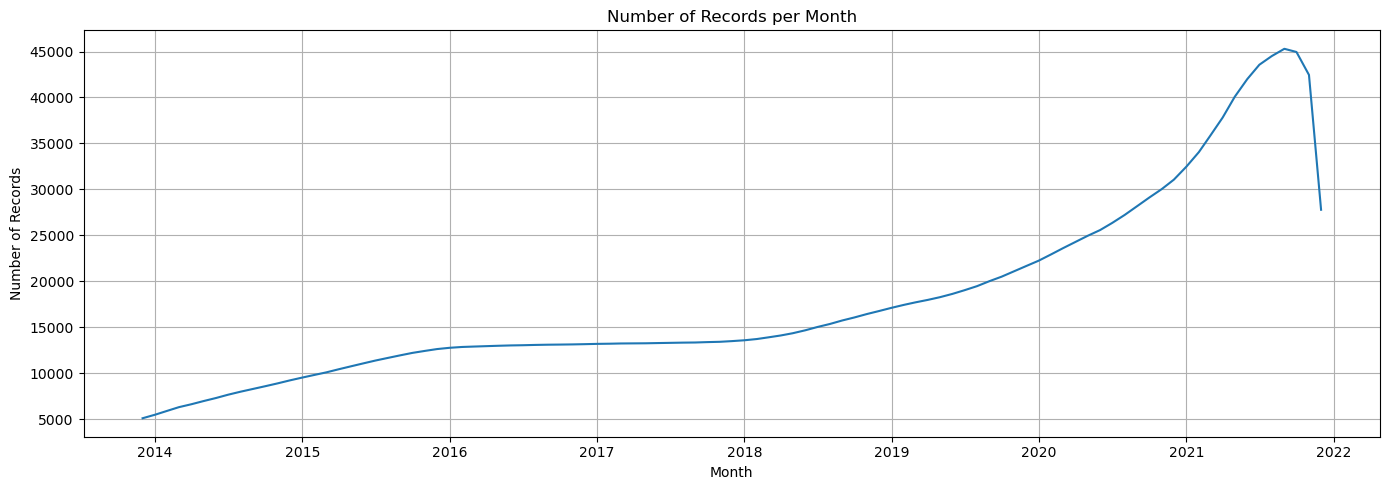

In [23]:
# Group by Year-Month and count records
monthly_counts = df.groupby(df['DATE'].dt.to_period('M')).size()

# Convert index to datetime for plotting
monthly_counts.index = monthly_counts.index.to_timestamp()

plt.figure(figsize=(14, 5))
plt.plot(monthly_counts.index, monthly_counts.values)
plt.title('Number of Records per Month')
plt.xlabel('Month')
plt.ylabel('Number of Records')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"time_distribution_dataset.png")
plt.show()

In [24]:
# Step 1: Get first activity date per client
first_dates = df.groupby('CLIENT_ID')['DATE'].min().reset_index()
first_dates.columns = ['CLIENT_ID', 'FIRST_DATE']

# Step 2: Filter clients with first activity after 2017
recent_clients = first_dates[first_dates['FIRST_DATE'] >= '2017-01-01']['CLIENT_ID']

# Step 3: Subset the main DataFrame to include only these clients
df_recent = df[df['CLIENT_ID'].isin(recent_clients)]

# Optional: Confirm how many clients remain
print(f"Filtered dataset contains {df_recent['CLIENT_ID'].nunique()} clients with activity starting in 2017 or later.")

# Total number of clients
total_clients = df['CLIENT_ID'].nunique()

# Clients with first activity after 2020
recent_clients_count = recent_clients.nunique()

# Calculate percentage
percentage = (recent_clients_count / total_clients) * 100

print(f"{recent_clients_count} out of {total_clients} clients ({percentage:.2f}%) started activity in 2017 or later.")


Filtered dataset contains 32899 clients with activity starting in 2017 or later.
32899 out of 46046 clients (71.45%) started activity in 2017 or later.


In [25]:
df = df_recent

In [26]:
# CLient history lenght
client_date_ranges = df.groupby('CLIENT_ID')['DATE'].agg(['min', 'max']).reset_index()
client_date_ranges.rename(columns={'min': 'start_date', 'max': 'end_date'}, inplace=True)
client_date_ranges['duration_months'] = (client_date_ranges['end_date'] - client_date_ranges['start_date']) / np.timedelta64(30, 'D')
client_date_ranges['duration_months'] = client_date_ranges['duration_months'].round(1)

display(client_date_ranges.head())

,CLIENT_ID,start_date,end_date,duration_months
0,ES182100006A,2021-07-29,2021-12-31,5.2
1,ES182100021X,2020-07-22,2021-11-30,16.5
2,ES182100023A,2021-02-24,2021-09-29,7.2
3,ES182100043N,2019-04-14,2021-12-31,33.1
4,ES182100047A,2018-10-10,2021-09-29,36.2


In [27]:
# Reuse the previous client_date_ranges DataFrame or compute if needed ---> 0 to 8 years of history
client_date_ranges = df.groupby('CLIENT_ID')['DATE'].agg(['min', 'max']).reset_index()
client_date_ranges.rename(columns={'min': 'start_date', 'max': 'end_date'}, inplace=True)
client_date_ranges['duration_months'] = (
    (client_date_ranges['end_date'] - client_date_ranges['start_date']) / np.timedelta64(30, 'D')
).round(1)

# Compute and display the min and max
min_months = client_date_ranges['duration_months'].min()
max_months = client_date_ranges['duration_months'].max()

print(f"Minimum client history: {min_months} months")
print(f"Maximum client history: {max_months} months")

Minimum client history: 0.0 months
Maximum client history: 59.9 months


In [28]:
# Get each client's first transaction date
first_dates = df.groupby('CLIENT_ID')['DATE'].min().reset_index()
first_dates.rename(columns={'DATE': 'FIRST_DATE'}, inplace=True)

In [29]:
# Step 3: Merge FIRST_DATE back into the original df
df = df.merge(first_dates, on='CLIENT_ID', how='left')

In [30]:
# Step 3: Compute difference in months manually
df['MONTH_DIFF'] = (
    (df['DATE'].dt.year - df['FIRST_DATE'].dt.year) * 12 +
    (df['DATE'].dt.month - df['FIRST_DATE'].dt.month)
)

In [31]:
# Step 5: Filter to keep only first 6 months of data per client
df_filtered = df[df['MONTH_DIFF'] <= 6].copy()

In [32]:
# Summary
print(f"Original rows: {df.shape[0]:,}")
print(f"Filtered rows (first 6 months): {df_filtered.shape[0]:,}")
print(f"Clients retained: {df_filtered['CLIENT_ID'].nunique()}")

Original rows: 569,305
Filtered rows (first 6 months): 217,081
Clients retained: 32899


In [33]:
df = df_filtered

## Feature Engineering

I created two new features to capture client payment and usage behavior:

- **PERCENT_BALANCE_PAID**: The percentage of the credit card balance that was paid off each month.  
- **CREDIT_UTILIZATION**: The ratio between the credit card balance and the credit card limit each month.

To capture behavioral trends over time, I also computed two new features:

- **PERCENT_CREDIT_UTILIZATION_TREND**: The change in credit utilization between the first and last observed month.  
- **PERCENT_BALANCE_PAID_TREND**: The change in the percentage of balance paid from the first to the last month.

Finally, to account for customer engagement across multiple agreements, I added:

- **NUM_CONTRACTS**: The total number of distinct contracts each client holds, indicating their level of product engagement.

These trend- and engagement-based features help assess whether clients are becoming more or less financially responsible and how broadly they interact the our products over time.  


In [34]:
# Make sure df is sorted
df = df.sort_values(by=['CLIENT_ID', 'DATE'])

In [35]:
# Feature 1: % of balance paid (0 to 100)
df['PERCENT_BALANCE_PAID'] = (df['CREDIT_CARD_PAYMENT'] * 100) / df['CREDIT_CARD_BALANCE'].replace(0, np.nan)
df['PERCENT_BALANCE_PAID'] = df['PERCENT_BALANCE_PAID'].fillna(0)

In [36]:
# Feature 2: % of credit utilization (0 to 100+)
df['PERCENT_CREDIT_UTILIZATION'] = (df['CREDIT_CARD_BALANCE'] *100) / df['CREDIT_CARD_LIMIT'].replace(0, np.nan)
df['PERCENT_CREDIT_UTILIZATION'] = df['PERCENT_CREDIT_UTILIZATION'].fillna(0)

In [37]:
# Ensure data is sorted
df = df.sort_values(by=['CLIENT_ID', 'DATE'])

# Compute trends directly in df
df['PERCENT_CREDIT_UTILIZATION_FIRST'] = df.groupby('CLIENT_ID')['PERCENT_CREDIT_UTILIZATION'].transform('first')
df['PERCENT_CREDIT_UTILIZATION_LAST'] = df.groupby('CLIENT_ID')['PERCENT_CREDIT_UTILIZATION'].transform('last')
df['PERCENT_CREDIT_UTILIZATION_TREND'] = (
    df['PERCENT_CREDIT_UTILIZATION_LAST'] - df['PERCENT_CREDIT_UTILIZATION_FIRST']
)

df['PERCENT_BALANCE_PAID_FIRST'] = df.groupby('CLIENT_ID')['PERCENT_BALANCE_PAID'].transform('first')
df['PERCENT_BALANCE_PAID_LAST'] = df.groupby('CLIENT_ID')['PERCENT_BALANCE_PAID'].transform('last')
df['PERCENT_BALANCE_PAID_TREND'] = (
    df['PERCENT_BALANCE_PAID_LAST'] - df['PERCENT_BALANCE_PAID_FIRST']
)

In [38]:
df.columns

Index(['CONTRACT_ID', 'CLIENT_ID', 'DATE', 'CREDIT_CARD_BALANCE',
       'CREDIT_CARD_LIMIT', 'CREDIT_CARD_DRAWINGS_ATM', 'CREDIT_CARD_DRAWINGS',
       'CREDIT_CARD_DRAWINGS_POS', 'CREDIT_CARD_DRAWINGS_OTHER',
       'CREDIT_CARD_PAYMENT', 'NUMBER_DRAWINGS_ATM', 'NUMBER_DRAWINGS',
       'NUMBER_INSTALMENTS', 'CURRENCY_x', 'NON_COMPLIANT_CONTRACT',
       'NAME_PRODUCT_TYPE', 'GENDER', 'TOTAL_INCOME', 'AMOUNT_PRODUCT',
       'INSTALLMENT', 'EDUCATION', 'MARITAL_STATUS', 'HOME_SITUATION',
       'REGION_SCORE', 'AGE_IN_YEARS', 'JOB_SENIORITY', 'HOME_SENIORITY',
       'LAST_UPDATE', 'OWN_INSURANCE_CAR', 'CAR_AGE', 'FAMILY_SIZE',
       'REACTIVE_SCORING', 'PROACTIVE_SCORING', 'BEHAVIORAL_SCORING',
       'DAYS_LAST_INFO_CHANGE', 'NUMBER_OF_PRODUCTS', 'OCCUPATION',
       'DIGITAL_CLIENT', 'HOME_OWNER', 'EMPLOYER_ORGANIZATION_TYPE',
       'CURRENCY_y', 'NUM_PREVIOUS_LOAN_APP', 'LOAN_ANNUITY_PAYMENT_MAX',
       'LOAN_ANNUITY_PAYMENT_MIN', 'LOAN_ANNUITY_PAYMENT_SUM',
       'LOAN_APPLI

In [39]:
df.shape

(217081, 68)

## Aggregation Strategy

To prepare the dataset for classification, I need one row per client. I followed this structured approach to define which columns to aggregate and which to retain as is:

1. **Select client-level columns that do not need to be aggregated**:  
   These are columns already available in the `clients_df` (e.g., demographic or static information about the client).

2. **Intersect with numerical columns**:  
   I computed the intersection between the columns in `clients_df` and the full set of numerical columns. These columns already exist at the client level and should not be aggregated.

3. **Identify numerical columns to aggregate**:  
   From the remaining numerical columns, I selected a focused subset of features that provide insight into the client's behavior over time. These include:

   - **Activity & usage**:  
     `'CREDIT_CARD_DRAWINGS'`, `'NUMBER_DRAWINGS_ATM'`, `'CREDIT_CARD_DRAWINGS_ATM'` (redundant but provides more granular insight into ATM withdrawals)
     
   - **Repayment behavior**:  
     `'CREDIT_CARD_PAYMENT'`, `'NUMBER_INSTALMENTS'`

   - **Available credit & balance**:  
     `'CREDIT_CARD_LIMIT'`, `'CREDIT_CARD_BALANCE'`

   - **Derived behavior features**:  
     `'PERCENT_BALANCE_PAID'`, `'PERCENT_CREDIT_UTILIZATION'`

   - **Trends**:  
     `'PERCENT_BALANCE_PAID_TREND'`, `'PERCENT_CREDIT_UTILIZATION_TREND'`

   - **Other relevant features**:  
     `'PERCENT_BALANCE_PAID_LAST'`, `'PERCENT_CREDIT_UTILIZATION_LAST'`, `'PERCENT_BALANCE_PAID_FIRST'`, `'PERCENT_CREDIT_UTILIZATION_FIRST'`, `'MONTH_DIFF'`
     
     - **`MONTH_DIFF`**: Represents the number of months since the client's first recorded transaction or event. This captures the duration of the client’s relationship with the product, which is important for identifying temporal trends in client behavior.
     
     - **`PERCENT_BALANCE_PAID_LAST`**, **`PERCENT_CREDIT_UTILIZATION_LAST`**, **`PERCENT_BALANCE_PAID_FIRST`**, **`PERCENT_CREDIT_UTILIZATION_FIRST`**: These features provide insights into the client’s most recent and first credit behavior, helping to capture initial and final patterns in their financial activity.

These variables will be aggregated using summary statistics (e.g., mean, std, min, max) to condense time-series information into client-level features that are informative for modeling the target variable (`NON_COMPLIANT_CONTRACT`).


In [40]:
df['CLIENT_ID'].nunique()

32899

In [41]:
# Make sure df is sorted
df = df.sort_values(by=['CLIENT_ID', 'DATE'])

In [42]:
# Step 1: Identify client-level columns (already present in clients_df)
client_level_columns = clients_df.columns.tolist()

In [43]:
# Step 2: Identify numeric columns from the transactions DataFrame
numeric_cols_df = df.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

In [44]:
# Step 3: Exclude client-level numeric columns from the aggregation list
numeric_cols_to_aggregate = list(set(numeric_cols_df) - set(client_level_columns))


In [45]:
# Step 4: Identify non-numeric columns (object, bool, etc.)
non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64', 'int32', 'datetime64[ns]']).columns.tolist()

In [46]:
# Step 5: Split non-numeric columns into two groups:
non_numeric_in_client_df = list(set(non_numeric_cols) & set(client_level_columns))
non_numeric_not_in_client_df = list(set(non_numeric_cols) - set(client_level_columns))

In [47]:
# Output
print(" Client-level columns (already present in clients_df):")
print(client_level_columns)

print("\n Numerical columns to aggregate (not present in clients_df):")
print(numeric_cols_to_aggregate)

print("\n Non-numeric columns in df (object, bool, etc.):")
print(non_numeric_cols)

print("\n Non-numeric columns already in clients_df (no need to aggregate but need to engineer):")
print(non_numeric_in_client_df)

print("\n Non-numeric columns NOT in clients_df (Need to engineer and aggregte):")
print(non_numeric_not_in_client_df)


 Client-level columns (already present in clients_df):
['CLIENT_ID', 'NON_COMPLIANT_CONTRACT', 'NAME_PRODUCT_TYPE', 'GENDER', 'TOTAL_INCOME', 'AMOUNT_PRODUCT', 'INSTALLMENT', 'EDUCATION', 'MARITAL_STATUS', 'HOME_SITUATION', 'REGION_SCORE', 'AGE_IN_YEARS', 'JOB_SENIORITY', 'HOME_SENIORITY', 'LAST_UPDATE', 'OWN_INSURANCE_CAR', 'CAR_AGE', 'FAMILY_SIZE', 'REACTIVE_SCORING', 'PROACTIVE_SCORING', 'BEHAVIORAL_SCORING', 'DAYS_LAST_INFO_CHANGE', 'NUMBER_OF_PRODUCTS', 'OCCUPATION', 'DIGITAL_CLIENT', 'HOME_OWNER', 'EMPLOYER_ORGANIZATION_TYPE', 'CURRENCY', 'NUM_PREVIOUS_LOAN_APP', 'LOAN_ANNUITY_PAYMENT_MAX', 'LOAN_ANNUITY_PAYMENT_MIN', 'LOAN_ANNUITY_PAYMENT_SUM', 'LOAN_APPLICATION_AMOUNT_MAX', 'LOAN_APPLICATION_AMOUNT_MIN', 'LOAN_APPLICATION_AMOUNT_SUM', 'LOAN_CREDIT_GRANTED_MAX', 'LOAN_CREDIT_GRANTED_MIN', 'LOAN_CREDIT_GRANTED_SUM', 'LOAN_VARIABLE_RATE_MAX', 'LOAN_VARIABLE_RATE_MIN', 'NUM_STATUS_ANNULLED', 'NUM_STATUS_AUTHORIZED', 'NUM_STATUS_DENIED', 'NUM_STATUS_NOT_USED', 'NUM_FLAG_INSURED']

 

In [48]:
# Clip negatives in numerical # I changed my mind regarding clipping as I decided I am going to focus on tree based models later on

#df[numeric_cols] = df[numeric_cols].clip(lower=0)

## Feature Aggregation

To transform transactional time-series data into a client-level dataset, I selected a subset of informative numerical variables. These features were grouped by `CLIENT_ID` and aggregated using statistical functions that capture both central tendency and variability:

- **mean, median, std, min, max**: Capture basic distributional statistics over time
- **first and last**: Represents the earliest and latest value available during the observation window

This approach condenses multi-month behavior into a compact and meaningful representation for each client, ready for modeling.


In [49]:
# Make sure df is sorted
df = df.sort_values(by=['CLIENT_ID', 'DATE'])

# Step 2: Keep only a subset of interest from numerical columns
numeric_cols_to_aggregate = [
    'PERCENT_CREDIT_UTILIZATION',
    'NUMBER_DRAWINGS',
    'PERCENT_CREDIT_UTILIZATION_TREND',
    'PERCENT_BALANCE_PAID_LAST',
    'CREDIT_CARD_DRAWINGS',
    'NUMBER_DRAWINGS_ATM',
    'NUMBER_INSTALMENTS',
    'CREDIT_CARD_BALANCE',
    'PERCENT_BALANCE_PAID_FIRST',
    'PERCENT_BALANCE_PAID',
    'CREDIT_CARD_LIMIT',
    'MONTH_DIFF',
    'CREDIT_CARD_DRAWINGS_OTHER',
    'CREDIT_CARD_DRAWINGS_ATM',  # Redundant, included
    'PERCENT_CREDIT_UTILIZATION_LAST',
    'CREDIT_CARD_PAYMENT',
    'CREDIT_CARD_DRAWINGS_POS',
    'PERCENT_BALANCE_PAID_TREND',
    'PERCENT_CREDIT_UTILIZATION_FIRST'
]

# Step 3: Aggregation dictionary with statistical functions
agg_dict = {col: ['mean', 'median','std', 'min', 'max', 'first','last'] for col in numeric_cols_to_aggregate}

# Step 4: Group and aggregate the transactions dataframe by CLIENT_ID
agg_transactions = df.groupby('CLIENT_ID').agg(agg_dict)

# Step 5: Flatten multi-level column names
agg_transactions.columns = ['_'.join(col).upper() for col in agg_transactions.columns]

# Step 6: Reset the index to include CLIENT_ID as a column
agg_transactions.reset_index(inplace=True)


In [50]:
agg_transactions.head()

,CLIENT_ID,PERCENT_CREDIT_UTILIZATION_MEAN,PERCENT_CREDIT_UTILIZATION_MEDIAN,PERCENT_CREDIT_UTILIZATION_STD,PERCENT_CREDIT_UTILIZATION_MIN,PERCENT_CREDIT_UTILIZATION_MAX,PERCENT_CREDIT_UTILIZATION_FIRST,PERCENT_CREDIT_UTILIZATION_LAST,NUMBER_DRAWINGS_MEAN,NUMBER_DRAWINGS_MEDIAN,...,PERCENT_BALANCE_PAID_TREND_MAX,PERCENT_BALANCE_PAID_TREND_FIRST,PERCENT_BALANCE_PAID_TREND_LAST,PERCENT_CREDIT_UTILIZATION_FIRST_MEAN,PERCENT_CREDIT_UTILIZATION_FIRST_MEDIAN,PERCENT_CREDIT_UTILIZATION_FIRST_STD,PERCENT_CREDIT_UTILIZATION_FIRST_MIN,PERCENT_CREDIT_UTILIZATION_FIRST_MAX,PERCENT_CREDIT_UTILIZATION_FIRST_FIRST,PERCENT_CREDIT_UTILIZATION_FIRST_LAST
0,ES182100006A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,ES182100021X,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,ES182100023A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,ES182100043N,92.929156,92.020273,5.095043,86.681287,99.893177,99.266472,89.204094,1.428571,0.0,...,0.0,0.0,0.0,99.266472,99.266472,0.0,99.266472,99.266472,99.266472,99.266472
4,ES182100047A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [51]:
agg_transactions.shape

(32899, 134)

In [52]:
#agg_transactions.columns

In [53]:
# Non-numeric columns NOT in client-level dataset:

In [54]:
# Count unique CONTRACT_IDs per CLIENT_ID
contract_counts = df.groupby('CLIENT_ID')['CONTRACT_ID'].nunique()

# Check how many clients have more than 1 contract
multiple_contracts = contract_counts[contract_counts > 1]

print(f" Clients with only one contract: {(contract_counts == 1).sum()}")
print(f" Clients with multiple contracts: {len(multiple_contracts)}")

# (Optional) Display a few examples
if not multiple_contracts.empty:
    print("\n Examples of clients with multiple contracts:")
    display(multiple_contracts.head())

 Clients with only one contract: 32877
 Clients with multiple contracts: 22

 Examples of clients with multiple contracts:


CLIENT_ID
ES182116071F    2
ES182161692C    2
ES182162601H    2
ES182165117P    2
ES182188377L    2
Name: CONTRACT_ID, dtype: int64

In [55]:
# Count number of unique contracts per client
contract_counts = df.groupby('CLIENT_ID')['CONTRACT_ID'].nunique().reset_index()
contract_counts.rename(columns={'CONTRACT_ID': 'NUM_CONTRACTS'}, inplace=True)

# Merge with the aggregated transactions data
agg_transactions = agg_transactions.merge(contract_counts, on='CLIENT_ID', how='left')

In [56]:
#agg_transactions.columns

In [57]:
# Merge aggregated features with client-level dataset on CLIENT_ID
training_df = clients_df.merge(agg_transactions, on='CLIENT_ID', how='inner')

print(f" Training dataset created with shape: {training_df.shape}")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(training_df.head())

 Training dataset created with shape: (32899, 179)


,CLIENT_ID,NON_COMPLIANT_CONTRACT,NAME_PRODUCT_TYPE,GENDER,TOTAL_INCOME,AMOUNT_PRODUCT,INSTALLMENT,EDUCATION,MARITAL_STATUS,HOME_SITUATION,REGION_SCORE,AGE_IN_YEARS,JOB_SENIORITY,HOME_SENIORITY,LAST_UPDATE,OWN_INSURANCE_CAR,CAR_AGE,FAMILY_SIZE,REACTIVE_SCORING,PROACTIVE_SCORING,BEHAVIORAL_SCORING,DAYS_LAST_INFO_CHANGE,NUMBER_OF_PRODUCTS,OCCUPATION,DIGITAL_CLIENT,HOME_OWNER,EMPLOYER_ORGANIZATION_TYPE,CURRENCY,NUM_PREVIOUS_LOAN_APP,LOAN_ANNUITY_PAYMENT_MAX,LOAN_ANNUITY_PAYMENT_MIN,LOAN_ANNUITY_PAYMENT_SUM,LOAN_APPLICATION_AMOUNT_MAX,LOAN_APPLICATION_AMOUNT_MIN,LOAN_APPLICATION_AMOUNT_SUM,LOAN_CREDIT_GRANTED_MAX,LOAN_CREDIT_GRANTED_MIN,LOAN_CREDIT_GRANTED_SUM,LOAN_VARIABLE_RATE_MAX,LOAN_VARIABLE_RATE_MIN,NUM_STATUS_ANNULLED,NUM_STATUS_AUTHORIZED,NUM_STATUS_DENIED,NUM_STATUS_NOT_USED,NUM_FLAG_INSURED,PERCENT_CREDIT_UTILIZATION_MEAN,PERCENT_CREDIT_UTILIZATION_MEDIAN,PERCENT_CREDIT_UTILIZATION_STD,PERCENT_CREDIT_UTILIZATION_MIN,PERCENT_CREDIT_UTILIZATION_MAX,PERCENT_CREDIT_UTILIZATION_FIRST,PERCENT_CREDIT_UTILIZATION_LAST,NUMBER_DRAWINGS_MEAN,NUMBER_DRAWINGS_MEDIAN,NUMBER_DRAWINGS_STD,NUMBER_DRAWINGS_MIN,NUMBER_DRAWINGS_MAX,NUMBER_DRAWINGS_FIRST,NUMBER_DRAWINGS_LAST,PERCENT_CREDIT_UTILIZATION_TREND_MEAN,PERCENT_CREDIT_UTILIZATION_TREND_MEDIAN,PERCENT_CREDIT_UTILIZATION_TREND_STD,PERCENT_CREDIT_UTILIZATION_TREND_MIN,PERCENT_CREDIT_UTILIZATION_TREND_MAX,PERCENT_CREDIT_UTILIZATION_TREND_FIRST,PERCENT_CREDIT_UTILIZATION_TREND_LAST,PERCENT_BALANCE_PAID_LAST_MEAN,PERCENT_BALANCE_PAID_LAST_MEDIAN,PERCENT_BALANCE_PAID_LAST_STD,PERCENT_BALANCE_PAID_LAST_MIN,PERCENT_BALANCE_PAID_LAST_MAX,PERCENT_BALANCE_PAID_LAST_FIRST,PERCENT_BALANCE_PAID_LAST_LAST,CREDIT_CARD_DRAWINGS_MEAN,CREDIT_CARD_DRAWINGS_MEDIAN,CREDIT_CARD_DRAWINGS_STD,CREDIT_CARD_DRAWINGS_MIN,CREDIT_CARD_DRAWINGS_MAX,CREDIT_CARD_DRAWINGS_FIRST,CREDIT_CARD_DRAWINGS_LAST,NUMBER_DRAWINGS_ATM_MEAN,NUMBER_DRAWINGS_ATM_MEDIAN,NUMBER_DRAWINGS_ATM_STD,NUMBER_DRAWINGS_ATM_MIN,NUMBER_DRAWINGS_ATM_MAX,NUMBER_DRAWINGS_ATM_FIRST,NUMBER_DRAWINGS_ATM_LAST,NUMBER_INSTALMENTS_MEAN,NUMBER_INSTALMENTS_MEDIAN,NUMBER_INSTALMENTS_STD,NUMBER_INSTALMENTS_MIN,NUMBER_INSTALMENTS_MAX,NUMBER_INSTALMENTS_FIRST,NUMBER_INSTALMENTS_LAST,CREDIT_CARD_BALANCE_MEAN,CREDIT_CARD_BALANCE_MEDIAN,CREDIT_CARD_BALANCE_STD,CREDIT_CARD_BALANCE_MIN,CREDIT_CARD_BALANCE_MAX,CREDIT_CARD_BALANCE_FIRST,CREDIT_CARD_BALANCE_LAST,PERCENT_BALANCE_PAID_FIRST_MEAN,PERCENT_BALANCE_PAID_FIRST_MEDIAN,PERCENT_BALANCE_PAID_FIRST_STD,PERCENT_BALANCE_PAID_FIRST_MIN,PERCENT_BALANCE_PAID_FIRST_MAX,PERCENT_BALANCE_PAID_FIRST_FIRST,PERCENT_BALANCE_PAID_FIRST_LAST,PERCENT_BALANCE_PAID_MEAN,PERCENT_BALANCE_PAID_MEDIAN,PERCENT_BALANCE_PAID_STD,PERCENT_BALANCE_PAID_MIN,PERCENT_BALANCE_PAID_MAX,PERCENT_BALANCE_PAID_FIRST,PERCENT_BALANCE_PAID_LAST,CREDIT_CARD_LIMIT_MEAN,CREDIT_CARD_LIMIT_MEDIAN,CREDIT_CARD_LIMIT_STD,CREDIT_CARD_LIMIT_MIN,CREDIT_CARD_LIMIT_MAX,CREDIT_CARD_LIMIT_FIRST,CREDIT_CARD_LIMIT_LAST,MONTH_DIFF_MEAN,MONTH_DIFF_MEDIAN,MONTH_DIFF_STD,MONTH_DIFF_MIN,MONTH_DIFF_MAX,MONTH_DIFF_FIRST,MONTH_DIFF_LAST,CREDIT_CARD_DRAWINGS_OTHER_MEAN,CREDIT_CARD_DRAWINGS_OTHER_MEDIAN,CREDIT_CARD_DRAWINGS_OTHER_STD,CREDIT_CARD_DRAWINGS_OTHER_MIN,CREDIT_CARD_DRAWINGS_OTHER_MAX,CREDIT_CARD_DRAWINGS_OTHER_FIRST,CREDIT_CARD_DRAWINGS_OTHER_LAST,CREDIT_CARD_DRAWINGS_ATM_MEAN,CREDIT_CARD_DRAWINGS_ATM_MEDIAN,CREDIT_CARD_DRAWINGS_ATM_STD,CREDIT_CARD_DRAWINGS_ATM_MIN,CREDIT_CARD_DRAWINGS_ATM_MAX,CREDIT_CARD_DRAWINGS_ATM_FIRST,CREDIT_CARD_DRAWINGS_ATM_LAST,PERCENT_CREDIT_UTILIZATION_LAST_MEAN,PERCENT_CREDIT_UTILIZATION_LAST_MEDIAN,PERCENT_CREDIT_UTILIZATION_LAST_STD,PERCENT_CREDIT_UTILIZATION_LAST_MIN,PERCENT_CREDIT_UTILIZATION_LAST_MAX,PERCENT_CREDIT_UTILIZATION_LAST_FIRST,PERCENT_CREDIT_UTILIZATION_LAST_LAST,CREDIT_CARD_PAYMENT_MEAN,CREDIT_CARD_PAYMENT_MEDIAN,CREDIT_CARD_PAYMENT_STD,CREDIT_CARD_PAYMENT_MIN,CREDIT_CARD_PAYMENT_MAX,CREDIT_CARD_PAYMENT_FIRST,CREDIT_CARD_PAYMENT_LAST,CREDIT_CARD_DRAWINGS_POS_MEAN,CREDIT_CARD_DRAWINGS_POS_MEDIAN,CREDIT_CARD_DRAWINGS_POS_STD,

In [58]:
#training_df.dtypes

# Pre-processing

###  Goal: Prepare the dataset for modeling by handling the target variable, missing values, categorical features, and numerical features.

## 1. Target Variable Distribution
#### Understand the balance of compliant (0) vs. non-compliant (1) clients.

**Imbalance:** Only about 10 % of clients are non-compliant, resulting in a 90/10 split.  
**Plan:** To ensure the risk model sees enough examples of both classes, I will apply **random undersampling** of the compliant (0) group **after** all preprocessing is done, allowing reuse of the same processed dataset for training other models.  


Target Variable Distribution (Counts):
NON_COMPLIANT_CONTRACT
0    29691
1     3208
Name: count, dtype: int64

Target Variable Distribution (Percentages):
NON_COMPLIANT_CONTRACT
0    90.25
1     9.75
Name: proportion, dtype: float64


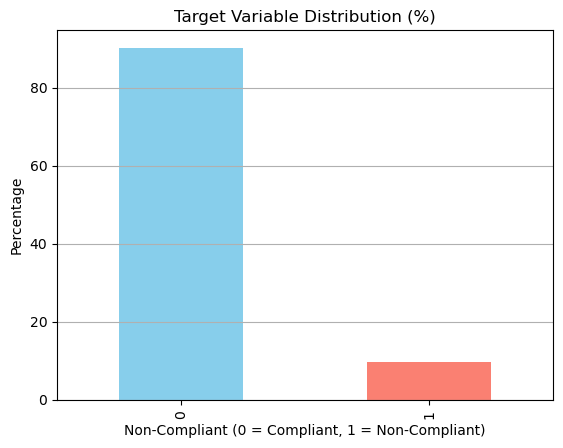

In [59]:
# Calculate the value counts and percentage
target_counts = training_df['NON_COMPLIANT_CONTRACT'].value_counts()
target_percentage = training_df['NON_COMPLIANT_CONTRACT'].value_counts(normalize=True) * 100

# Display
print("Target Variable Distribution (Counts):")
print(target_counts)
print("\nTarget Variable Distribution (Percentages):")
print(target_percentage.round(2))


target_percentage.plot(kind='bar', color=['skyblue', 'salmon'], title='Target Variable Distribution (%)')
plt.ylabel('Percentage')
plt.xlabel('Non-Compliant (0 = Compliant, 1 = Non-Compliant)')
plt.grid(axis='y')
#plt.savefig(f"target_variable_noncompliant.png")
plt.show()


## Missing Data Imputation

In our pipeline, we handle missing values consistently:

- **Numerical features**: Fill missing entries with the **median** of the column, preserving the original distribution and reducing the impact of outliers.  
- **Categorical features**: Fill missing entries with a new category **“Missing”**, ensuring that no rows are dropped and that the model can learn any signal in the fact that data was absent.  

This is implemented in `impute_missing_values(df)`, which loops over each column and applies the above rules in-place.

**Note:** If I had more time, I would specifically target variables with **>20% missingness** that are important for risk and propensity (e.g. `BEHAVIORAL_SCORING` and`PROACTIVE_SCORING`) and explore **multivariate imputation**—for example, building a small regression model to predict missing values from other related features.  


In [60]:
# Step 1: Analyze missingness
missing_values = training_df.isnull().sum()
missing_percentage = (missing_values / training_df.shape[0]) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Filter columns where the percentage of missing values is greater than 0
missing_summary = missing_summary[missing_summary['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

# Step 2: Add a "type" column to indicate whether the column is categorical or numerical
missing_summary['type'] = missing_summary.index.map(lambda col: 'categorical' if training_df[col].dtype == 'object' else 'numerical')

# Show the missing values summary with the "type" column
display(missing_summary)

,Missing Values,Percentage,type
CAR_AGE,22346,67.923037,numerical
REACTIVE_SCORING,17652,53.655126,numerical
EDUCATION,7530,22.888234,categorical
BEHAVIORAL_SCORING,6594,20.043162,numerical
NUMBER_OF_PRODUCTS,4570,13.891000,numerical
EMPLOYER_ORGANIZATION_TYPE,4386,13.331712,categorical
JOB_SENIORITY,4326,13.149336,numerical
PERCENT_CREDIT_UTILIZATION_FIRST_STD,326,0.990912,numerical
PERCENT_BALANCE_PAID_STD,326,0.990912,numerical
PERCENT_CREDIT_UTILIZATION_TREND_STD,326,0.990912,numerical


In [61]:
def impute_missing_values(df):
    """
    This function imputes missing values in the DataFrame.
    - Numerical columns are imputed with the median.
    - Categorical columns are imputed with a new category 'Missing'.

    Parameters:
    df (pd.DataFrame): The input DataFrame with missing values to impute.

    Returns:
    pd.DataFrame: The DataFrame with imputed missing values.
    """
    
    # Loop through each column and apply the appropriate imputation strategy
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:  # Numerical columns
            # Impute missing numerical values with the median
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
        
        elif df[col].dtype == 'object':  # Categorical columns
            # Impute missing categorical values with a new category 'Missing'
            df[col].fillna('Missing', inplace=True)
    
    return df

In [62]:
training_df = impute_missing_values(training_df)

In [63]:
training_df.head()

,CLIENT_ID,NON_COMPLIANT_CONTRACT,NAME_PRODUCT_TYPE,GENDER,TOTAL_INCOME,AMOUNT_PRODUCT,INSTALLMENT,EDUCATION,MARITAL_STATUS,HOME_SITUATION,...,PERCENT_BALANCE_PAID_TREND_FIRST,PERCENT_BALANCE_PAID_TREND_LAST,PERCENT_CREDIT_UTILIZATION_FIRST_MEAN,PERCENT_CREDIT_UTILIZATION_FIRST_MEDIAN,PERCENT_CREDIT_UTILIZATION_FIRST_STD,PERCENT_CREDIT_UTILIZATION_FIRST_MIN,PERCENT_CREDIT_UTILIZATION_FIRST_MAX,PERCENT_CREDIT_UTILIZATION_FIRST_FIRST,PERCENT_CREDIT_UTILIZATION_FIRST_LAST,NUM_CONTRACTS
0,ES182154395P,0,PRODUCT 1,M,1350.0,3234.60,298.24,Secondary,Single,House,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1
1,ES182400170J,0,PRODUCT 1,F,1080.0,15522.03,455.38,Missing,Married,House,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1
2,ES182189427K,1,PRODUCT 1,F,2430.0,11634.95,619.87,Secondary,Married,House,...,4.375282,4.375282,26.535926,26.535926,0.0,26.535926,26.535926,26.535926,26.535926,1
3,ES182212741F,0,PRODUCT 1,M,2862.0,3983.04,204.93,Secondary,Married,House,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1
4,ES182191583N,0,PRODUCT 1,M,2700.0,6222.74,248.35,Secondary,Married,House,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1


In [64]:
training_df.shape

(32899, 179)

In [65]:
training_df[['CLIENT_ID']].drop_duplicates().shape

(32899, 1)

In [66]:
# Quick check after imputation
missing_values_after = training_df.isnull().sum()

# Display only columns where there are still missing values
missing_values_after = missing_values_after[missing_values_after > 0]

# Display the result
print(missing_values_after)

Series([], dtype: int64)


In [67]:
#Raw dataframe
raw_df = training_df

## 3. Preprocess Categorical Variables  
#### Strategy:  
- **One-hot encode** (drop_first=True) for binary variables:  
  `NAME_PRODUCT_TYPE`, `GENDER`, `MARITAL_STATUS`, `OWN_INSURANCE_CAR`, `HOME_OWNER`  
- **Ordinal encode** with custom order for multi-level variables:  
  - `EDUCATION`  
  - `HOME_SITUATION`  
  - `OCCUPATION`  
- **Label encode** with a fixed mapping for production on high-cardinality variable:  
  `EMPLOYER_ORGANIZATION_TYPE`  


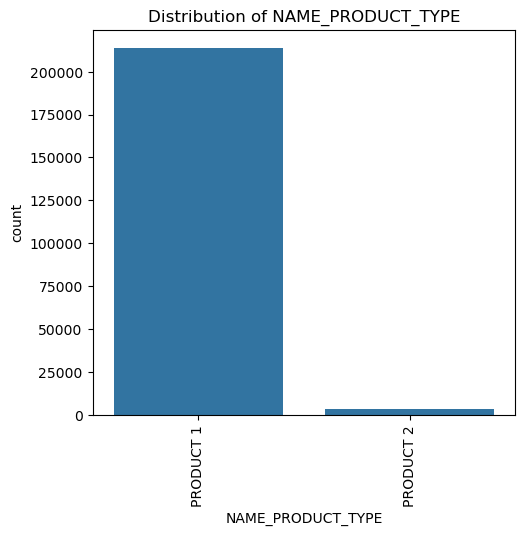

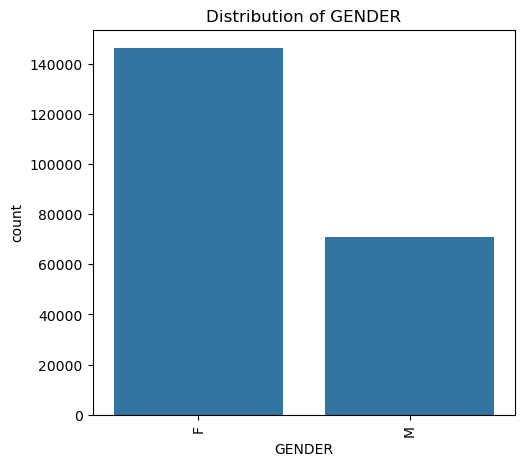

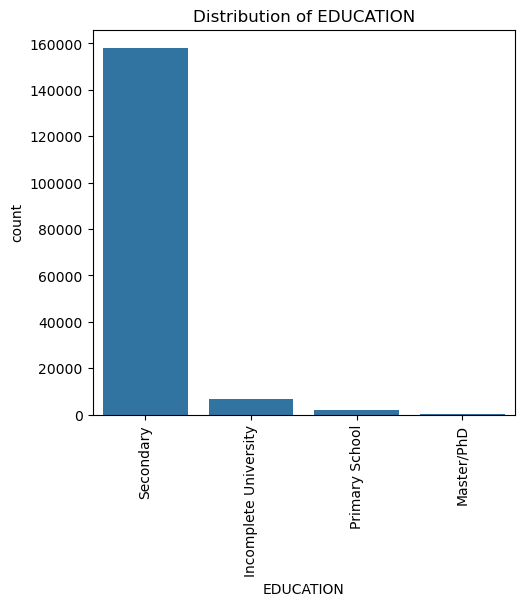

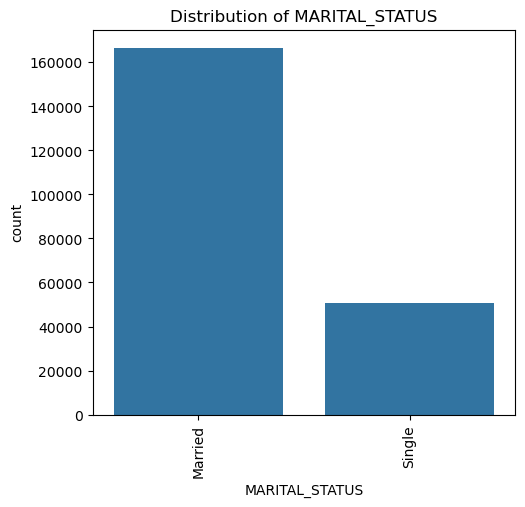

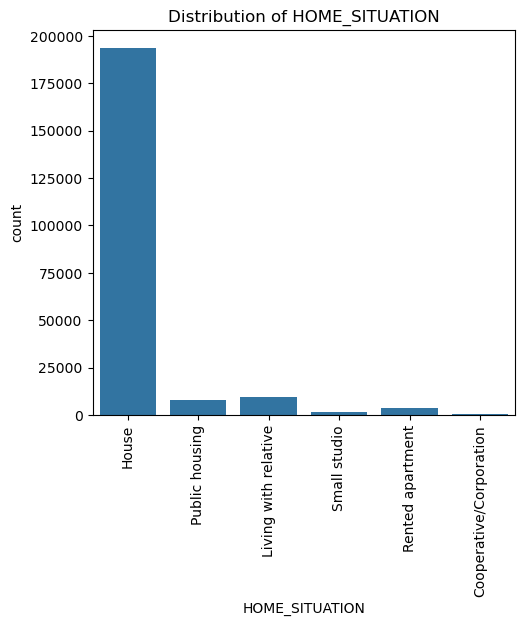

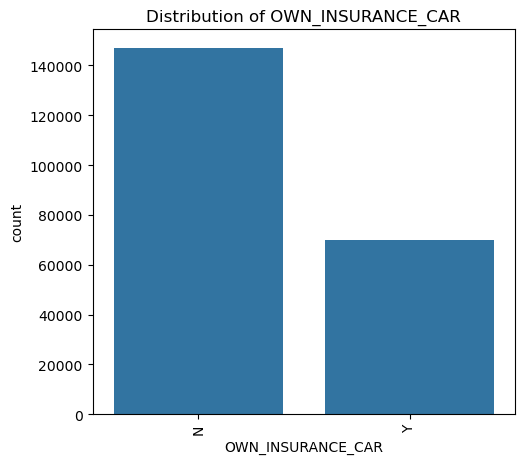

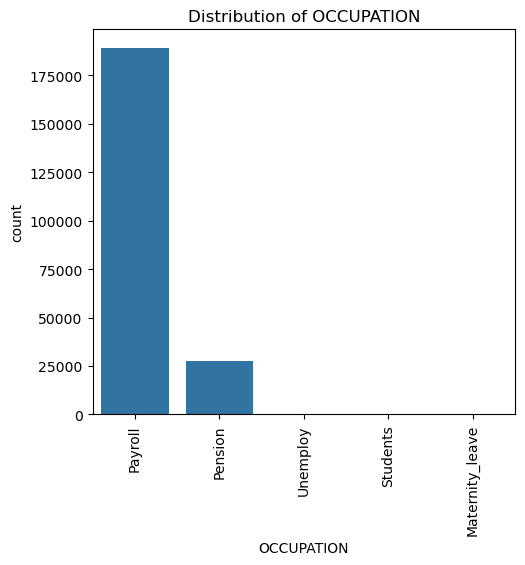

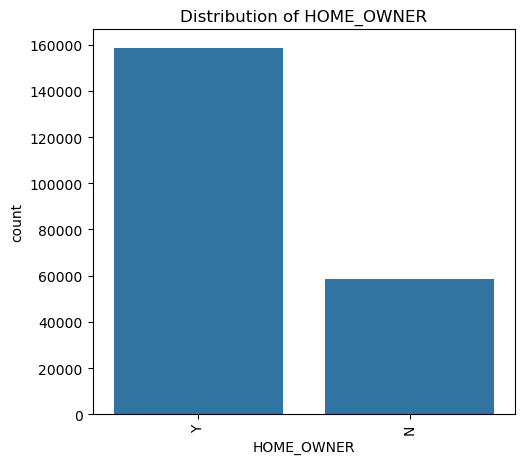

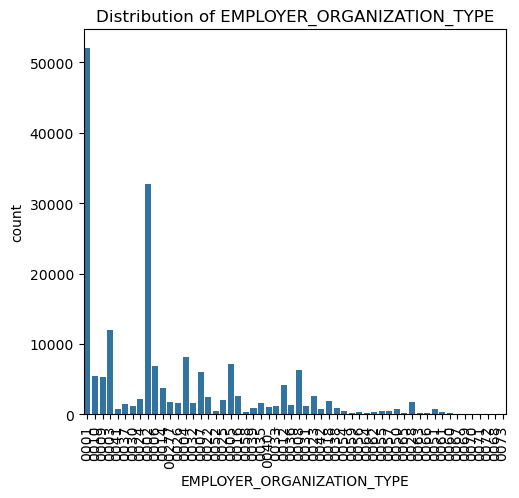

In [68]:
# Step 1: Extract categorical variables
categorical = training_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Exclude 'CLIENT_ID' and 'CURRENCY' from categorical columns
categorical = [col for col in categorical if col not in ['CLIENT_ID', 'CURRENCY']]

# Step 2: Plot categorical distributions
for i, column in enumerate(categorical):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plot = sns.countplot(x=column, data=df)
    plt.setp(plot.get_xticklabels(), rotation=90)
    plt.title(f'Distribution of {column}')
    plt.show()

In [69]:
# Step 3: Identify binary and non-binary categorical columns
binary_categorical = [col for col in categorical if df[col].nunique() == 2]
non_binary_categorical = [col for col in categorical if df[col].nunique() > 2]

# Display the results
print("Binary Categorical Variables:")
print(binary_categorical)
print("\nNon-Binary Categorical Variables:")
print(non_binary_categorical)

Binary Categorical Variables:
['NAME_PRODUCT_TYPE', 'GENDER', 'MARITAL_STATUS', 'OWN_INSURANCE_CAR', 'HOME_OWNER']

Non-Binary Categorical Variables:
['EDUCATION', 'HOME_SITUATION', 'OCCUPATION', 'EMPLOYER_ORGANIZATION_TYPE']


In [70]:
# Step 4: Apply One-Hot Encoding for binary variables with drop_first=True
df_encoded = pd.get_dummies(training_df, columns=binary_categorical, drop_first=True)

# Check the result
#print(df_encoded.head())

In [71]:
training_df = df_encoded

In [72]:
# Ordinal Encoding: Apply custom order to categorical variables

# 1. Define the order for 'EDUCATION', 'HOME_SITUATION', and 'OCCUPATION'
education_order = ["Master/PhD", "Bachelor", "Incomplete University",  "Secondary", "Primary School","Missing"]
home_situation_order = ["Cooperative/Corporation", "House", "Public housing", "Small studio", "Rented apartment", "Living with relative"]
occupation_order = ["Payroll", "Maternity_leave", "Pension", "Students", "Unemploy"]

# 2. Convert columns to categorical types with 'ordered=True'
training_df['EDUCATION'] = pd.Categorical(training_df['EDUCATION'], categories=education_order, ordered=True)
training_df['HOME_SITUATION'] = pd.Categorical(training_df['HOME_SITUATION'], categories=home_situation_order, ordered=True)
training_df['OCCUPATION'] = pd.Categorical(training_df['OCCUPATION'], categories=occupation_order, ordered=True)

# 3. Apply ordinal encoding by converting categories to integers
training_df['EDUCATION_encoded'] = training_df['EDUCATION'].cat.codes
training_df['HOME_SITUATION_encoded'] = training_df['HOME_SITUATION'].cat.codes
training_df['OCCUPATION_encoded'] = training_df['OCCUPATION'].cat.codes

# Display the result for 'EDUCATION'
print(training_df[['EDUCATION', 'EDUCATION_encoded']].value_counts())

EDUCATION              EDUCATION_encoded
Secondary              3                    23994
Missing                5                     7530
Incomplete University  2                     1028
Primary School         4                      326
Master/PhD             0                       21
Name: count, dtype: int64


In [73]:
# Drop original categorical columns after encoding
training_df.drop(['EDUCATION', 'HOME_SITUATION', 'OCCUPATION'], axis=1, inplace=True)

In [74]:
#Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to 'EMPLOYER_ORGANIZATION_TYPE'
# Label Encoding is used here because 'EMPLOYER_ORGANIZATION_TYPE' is a categorical variable with no intrinsic order.
# Each unique category will be assigned a unique integer value, which can be used in machine learning algorithms.
training_df['EMPLOYER_ORGANIZATION_TYPE_encoded'] = label_encoder.fit_transform(training_df['EMPLOYER_ORGANIZATION_TYPE'])

# Drop the original 'EMPLOYER_ORGANIZATION_TYPE' column as we no longer need the string representation
training_df.drop('EMPLOYER_ORGANIZATION_TYPE', axis=1, inplace=True)

# Display the result for 'EMPLOYER_ORGANIZATION_TYPE_encoded'
#df[['EMPLOYER_ORGANIZATION_TYPE_encoded']].value_counts()

# Note for production:
# In a production environment, a fixed dictionary mapping would need to be created for 'EMPLOYER_ORGANIZATION_TYPE'.
# This ensures that the encoding is consistent when new data is encountered, preventing issues with unseen categories.
# This mapping can be stored in a dictionary or similar structure to maintain consistency across different environments.

In [75]:
# Cast the 'EMPLOYER_ORGANIZATION_TYPE_encoded' column to int8
training_df['EMPLOYER_ORGANIZATION_TYPE_encoded'] = training_df['EMPLOYER_ORGANIZATION_TYPE_encoded'].astype('int8')

## 4. Preprocess Numerical Variables

#### Strategy for Linear Models (illustrative; **not** applied to tree-based models)
- **Clip negatives**: set any negative values (e.g. balances, counts) to zero.  
- **Compute skewness**: measure the asymmetry of each numeric feature.  
- **Log1p transform**: apply `np.log1p()` to features with high |skewness| (e.g. >1) to reduce long tails.  

**Note:** This code is provided for completeness but is **not** used in our tree-based pipelines, which are robust to skew and outliers.  

In [76]:
# Step 1: Extract continuous variables (including int64 and int32)
continuous = [column for column in training_df.columns if training_df[column].dtype in ['float64', 'int64', 'int32']]
#continuous

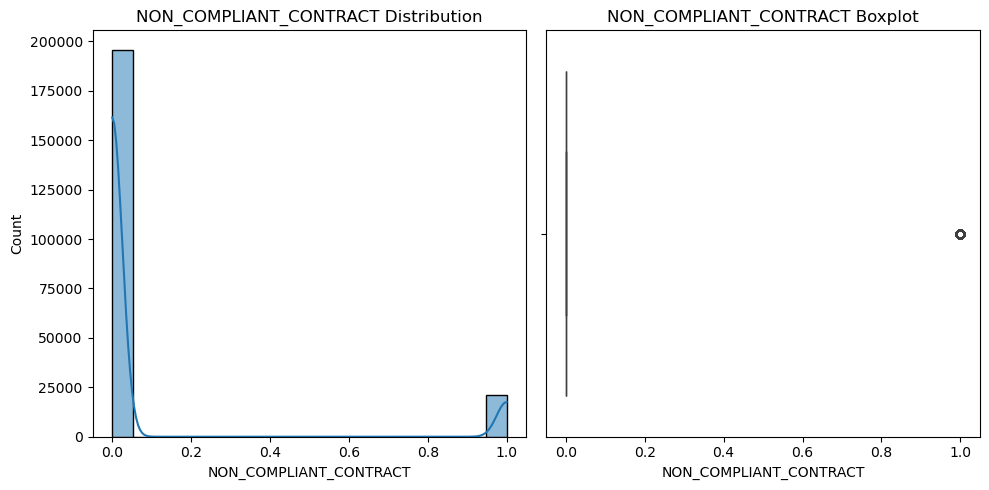

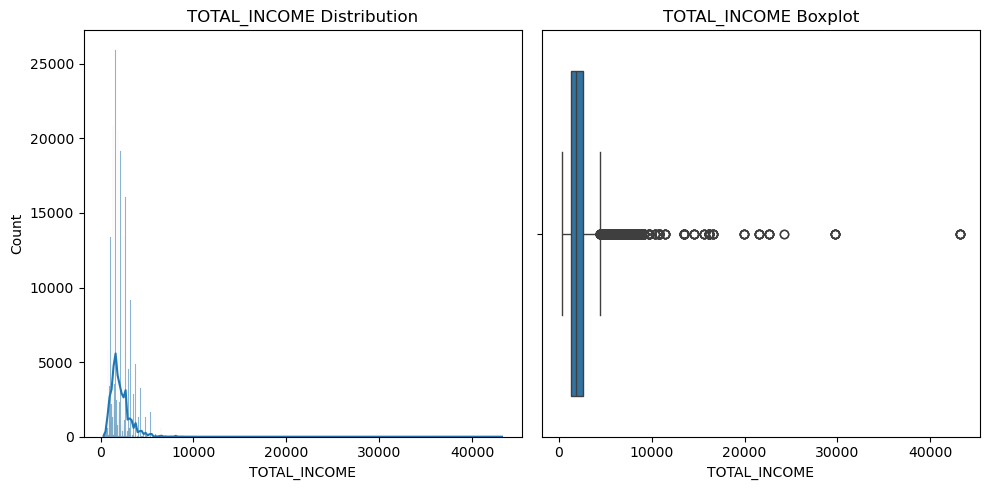

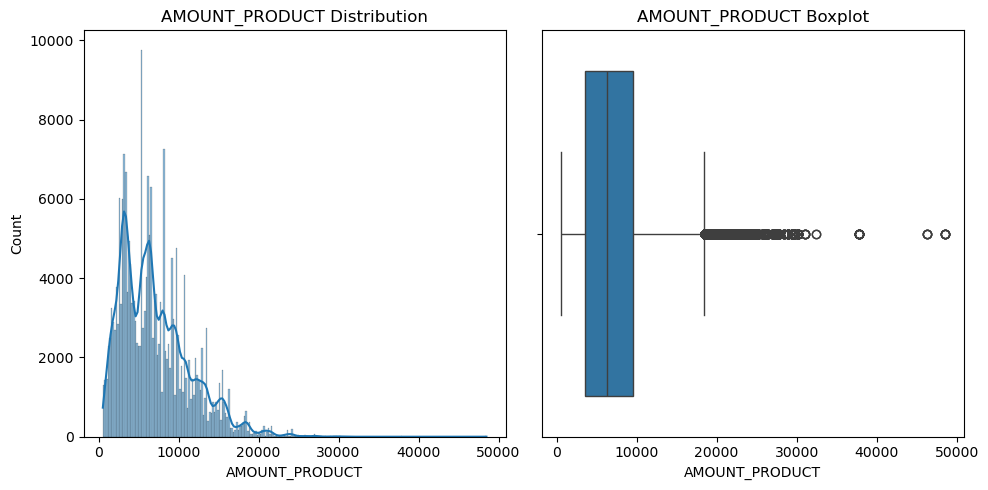

In [77]:
# Limit to first three continuous columns for display
for i, column in enumerate(continuous[:3]):  # Adjusting the loop to only use the first 3 columns
    plt.figure(figsize=(10, 5))
    
    # Plot histogram with kernel density estimate (KDE)
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'{column} Distribution')
    
    # Plot boxplot to show distribution spread and potential outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'{column} Boxplot')

    plt.tight_layout()
    plt.show()

In [78]:
def transform_skewed_columns_for_linear_models(df):
    """
    This function calculates the skewness for continuous columns.
    If skewness > 0.5, it applies a log1p transformation to the column.
    This is typically used for linear models to stabilize variance and achieve normality in residuals.
    It's not needed for tree-based models (e.g., Random Forest, XGBoost).
    """
    # Create a copy of the dataframe to avoid modifying the original df
    df_copy = df.copy()

    # List of continuous columns (float64, int64, int32)
    continuous = [column for column in df_copy.columns if df_copy[column].dtype in ['float64', 'int64', 'int32']]

    # List to store columns that would be log-transformed
    log_transformed = []

    # Clip negative values before any transformations (important for transformations like log1p)
    df_copy[continuous] = df_copy[continuous].clip(lower=0)

    skewed_count = 0  # Counter to track how many columns are skewed

    # Measure skewness for continuous columns and apply log1p transformation if skew > 0.5
    for column in continuous:
        # Handle NaN and infinite values before calculating skewness
        df_column = df_copy[column].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
        df_column = df_column.dropna()  # Drop NaNs

        column_skewness = skew(df_column)
        
        if abs(column_skewness) > 0.5:
            # Apply log1p transformation on skewed columns
            df_copy[column + '_log'] = np.log1p(df_copy[column])
            log_transformed.append(column)  # Track log-transformed columns
            skewed_count += 1  # Increment skewed columns count

    # Print how many columns are skewed and were transformed
    print(f"Number of skewed columns (with skewness > 0.5): {skewed_count} out of {len(continuous)}")

    # Show distribution before and after transformation for a couple of examples
    for column in log_transformed[:2]:  # Limit to just two columns for illustration
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        sns.histplot(df_copy[column], ax=ax1, kde=True)
        ax1.set_title(f'{column} Distribution Before Log Transform')

        sns.histplot(df_copy[column + '_log'], ax=ax2, kde=True)
        ax2.set_title(f'{column} Distribution After Log Transform')

        plt.tight_layout()
        plt.show()

    return df_copy  # Return the modified DataFrame with the transformed columns


In [79]:
#Illustrative example. Not using this for this current training dataset.
#df_test = transform_skewed_columns(df)

## 5. Downsample Majority Class

To balance the target, I downsampled the compliant (0) class to match the non-compliant (1) class at a 1:1 ratio, resulting in a balanced dataset of 6,416 rows (3,208 compliant and 3,208 non-compliant).

**Note:** If I had more time, I would explore alternative balancing strategies—such as SMOTE or over-sampling approach—to preserve more client records while still addressing the class imbalance.


In [80]:
df = training_df

In [81]:
# Separate the majority and minority classes
majority_class = df[df['NON_COMPLIANT_CONTRACT'] == 0]
minority_class = df[df['NON_COMPLIANT_CONTRACT'] == 1]

# Randomly sample the majority class to match the minority class size
majority_class_downsampled = majority_class.sample(n=minority_class.shape[0], random_state=42)

# Concatenate the downsampled majority class with the minority class
balanced_df = pd.concat([majority_class_downsampled, minority_class])

# Shuffle the final dataset to ensure randomness
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the new class distribution
print(balanced_df['NON_COMPLIANT_CONTRACT'].value_counts())

NON_COMPLIANT_CONTRACT
1    3208
0    3208
Name: count, dtype: int64


In [82]:
balanced_df.shape

(6416, 179)

In [83]:
#balanced_df[['CLIENT_ID']].drop_duplicates().shape

In [84]:
df = balanced_df

# Train-Test Split for Feature Selection

**Purpose:** This initial split is used **only** for feature selection with a basic Random Forest on all ~179 features. After identifying the final feature subset, I will perform a new train-test split using only those selected features.


In [85]:
# Set display options to show more rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Automatically adjust the display width
pd.set_option('display.max_colwidth', None)  # Show full column content

#print(df.columns.tolist())

In [86]:
# Save CLIENT_ID separately before dropping it
client_ids = df['CLIENT_ID']
    
# Drop 'CLIENT_ID' as it's not used for model training
df = df.drop(['CLIENT_ID','CURRENCY'], axis=1)

# Since I have already downsampled the majority class I don't need to stratify the target variable
def finance_train_test_split(df, target_column='NON_COMPLIANT_CONTRACT', test_size=0.3, random_state=123):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X, y, X_train, X_test, y_train, y_test

In [87]:
# Split the data into training and test sets
X, y, X_train, X_test, y_train, y_test = finance_train_test_split(df, test_size=0.3, random_state=123)

# Scaling Continuous Variables

_Illustrative only_: for linear models, I would standardize all continuous features by fitting a `StandardScaler` on `X_train` and then transforming both `X_train` and `X_test`. Since I’m using tree-based models (which don’t require scaling), this code is provided as a reference but is **not** executed in the pipeline.  


In [88]:
def scale_continuous_variables(X_train, X_test, columns_to_scale=None):
    """
    Scale continuous variables using StandardScaler.
    This function is used for linear models to ensure that all features are on the same scale.
    
    Arguments:
    - X_train: Training set features (DataFrame).
    - X_test: Test set features (DataFrame).
    - columns_to_scale: List of columns to scale. If None, it will select all columns of type 'float64'.
    
    Returns:
    - X_train: Scaled training set features.
    - X_test: Scaled test set features.
    """
    # If columns_to_scale is not provided, select all 'float64' columns
    if columns_to_scale is None:
        columns_to_scale = [column for column in X_train.columns if X_train[column].dtype == 'float64']
    
    print(f"Columns to scale: {columns_to_scale}")
    
    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

    # Save the scaler to a file to be used on the test data
    joblib.dump(scaler, '../models/scaler.pkl')

    # Later, you can load the scaler to use it on the test data
    X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    
    return X_train, X_test


In [89]:
#This is an illustrative example of what I would do if I wanted to used a linear model. Since I will be using tree based models. I wouln't be scaling my features. 

#X_train, X_test = scale_continuous_variables(X_train, X_test, columns_to_scale=None)

## Feature Selection with Random Forest

To cut down from ~140 features to a lean, powerful set, I do the following:

1. **Fit a basic Random Forest** on `X_train, y_train` and grab its built-in `feature_importances_`.  
2. **Compute permutation importances** on the same train/test split to get a second ranking.  
3. **Pick the top 50** from each ranking and **keep only features** that appear in both lists.  
4. **Check correlations** among those common features and find any pairs with |corr| > 0.8.  
5. **For each correlated pair**, drop the one with the lower permutation importance.  
6. **Result:** a final feature list that’s both highly predictive and free of redundancy.  



In [90]:
def get_rf_feature_importances(
    X_train, 
    y_train,
    model=None,
    n_estimators=100,
    random_state=42,
    plot=True,
    top_n=40,
    figsize=(10, 6)
):
    # 1. Instantiate or use provided RF
    rf = model if model is not None else RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    # 2. Fit
    rf.fit(X_train, y_train)
    # 3. Build DataFrame
    feat_importances_df = (
        pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': rf.feature_importances_
        })
        .sort_values('Importance', ascending=False)
        .reset_index(drop=True)
    )

    # 4. Optional plotting
    if plot:
        plt.figure(figsize=figsize)
        sns.barplot(
            x='Importance',
            y='Feature',
            data=feat_importances_df.head(top_n)
        )
        plt.title('Random Forest Feature Importances')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    return rf, feat_importances_df

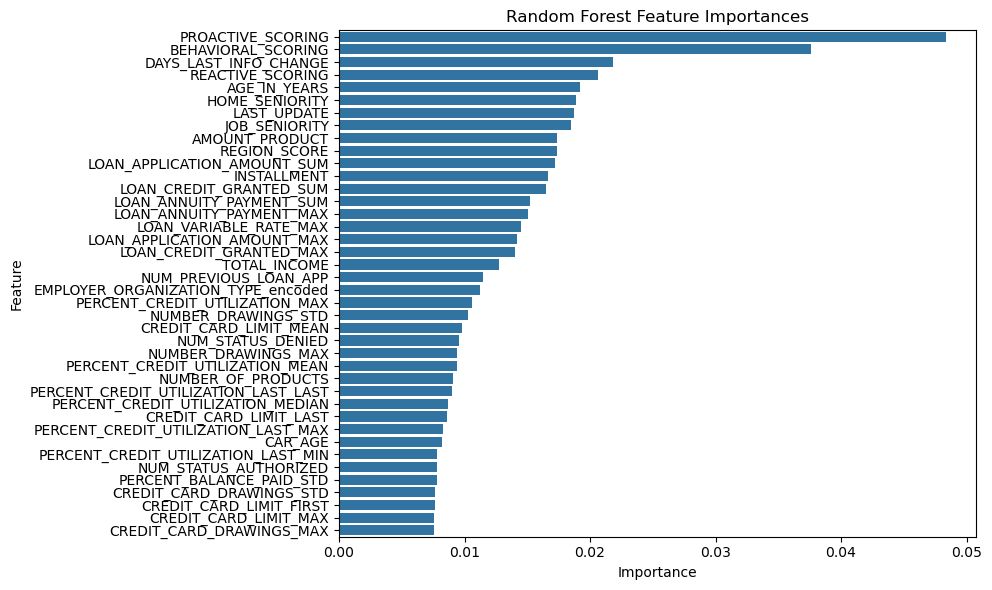

In [91]:
rf, feat_importances_df = get_rf_feature_importances(X_train, y_train, top_n=40)

In [92]:
#feat_importances_df.to_csv('feat_importances.csv')

/tmp/ipykernel_47777/3858983005.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


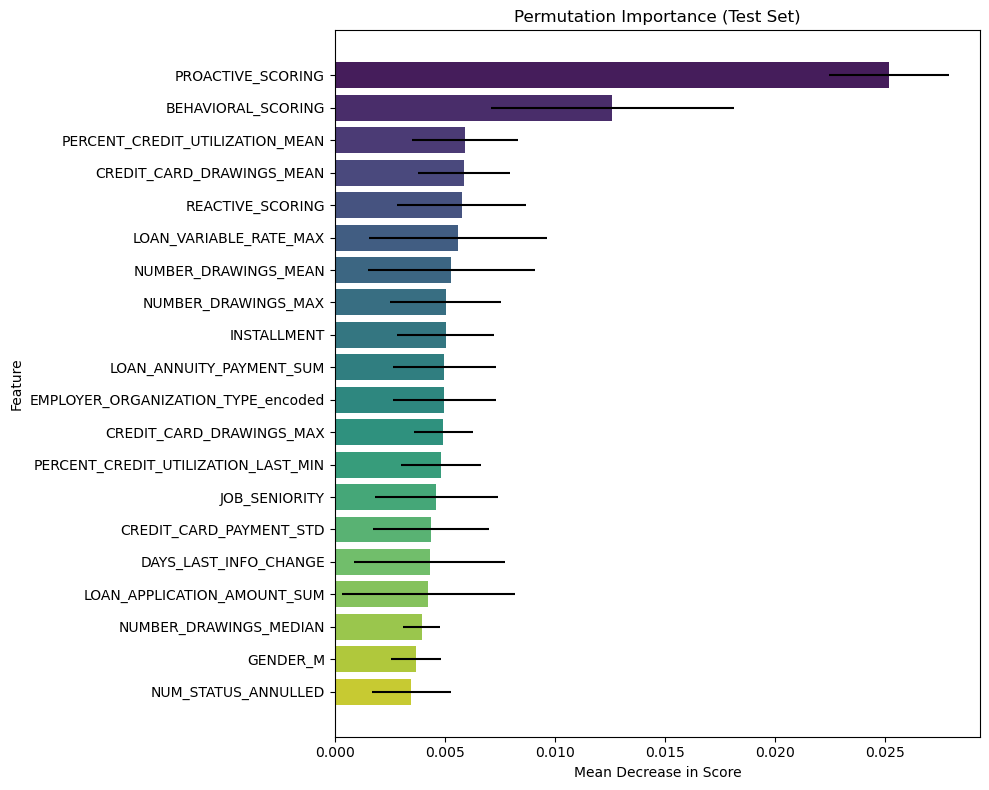

In [93]:
def get_permutation_importances(model,X_test,y_test,feature_names=None,n_repeats=10,random_state=42,n_jobs=-1,plot=True,top_n=20,figsize=(10, 8)):
    # Compute permutation importance
    perm_res = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=n_repeats,
        random_state=random_state,
        n_jobs=n_jobs
    )

    # Determine feature names
    names = feature_names if feature_names is not None else (
        X_test.columns if hasattr(X_test, "columns") else np.arange(len(perm_res.importances_mean))
    )

    # Build and sort DataFrame
    perm_importances_df = (
        pd.DataFrame({
            'feature': names,
            'importance_mean': perm_res.importances_mean,
            'importance_std' : perm_res.importances_std
        })
        .sort_values('importance_mean', ascending=False)
        .reset_index(drop=True)
    )

    # Optional plotting
    if plot:
        top = perm_importances_df.head(top_n)
        plt.figure(figsize=figsize)
        sns.barplot(
            x='importance_mean',
            y='feature',
            data=top,
            palette='viridis',
            orient='h'
        )
        plt.errorbar(
            x=top['importance_mean'],
            y=np.arange(len(top)),
            xerr=top['importance_std'],
            fmt='none',
            c='black'
        )
        plt.title('Permutation Importance (Test Set)')
        plt.xlabel('Mean Decrease in Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    return perm_importances_df

perm_importances_df = get_permutation_importances(rf, X_test, y_test, feature_names=X_train.columns, top_n=20)

In [94]:
#perm_importances_df.to_csv('permutation_importance.csv')

In [95]:
def select_features( feat_importances_df, perm_importances_df, X_train, N=50, corr_threshold=0.8
):
    # Step 2: get top-N lists
    topN_rf = feat_importances_df['Feature'].head(N).tolist()
    topN_perm = perm_importances_df['feature'].head(N).tolist()

    # Step 3: intersection
    common_features = list(set(topN_rf) & set(topN_perm))
    print(f"Common features (top {N} RF ∩ top {N} Perm): {common_features}")

    # Step 4: correlation matrix among the common features
    corr_matrix = X_train[common_features].corr().abs()

    # Step 5: identify highly correlated pairs
    high_corr_pairs = []
    for i, f1 in enumerate(common_features):
        for f2 in common_features[i+1:]:
            corr_val = corr_matrix.loc[f1, f2]
            if corr_val > corr_threshold:
                high_corr_pairs.append((f1, f2, corr_val))

    print("\nHighly correlated feature pairs (|corr| > "
          f"{corr_threshold}):")
    for f1, f2, cv in high_corr_pairs:
        print(f"  {f1} & {f2}: {cv:.2f}")

    # Step 6: drop the lower-permutation-importance feature from each pair
    perm_imp_dict = perm_importances_df.set_index('feature')['importance_mean'].to_dict()
    dropped = set()
    for f1, f2, _ in high_corr_pairs:
        if perm_imp_dict.get(f1, 0) < perm_imp_dict.get(f2, 0):
            dropped.add(f1)
        else:
            dropped.add(f2)

    # Step 7: final selected features
    selected_features = [f for f in common_features if f not in dropped]

    print("\nFeatures dropped due to high correlation:")
    print(dropped)
    print("\nFinal selected features:")
    print(selected_features)

    return selected_features, dropped, common_features

In [96]:
selected, dropped, common = select_features(
    feat_importances_df,
    perm_importances_df,
    X_train,
    N=50,
    corr_threshold=0.8
)


Common features (top 50 RF ∩ top 50 Perm): ['PERCENT_CREDIT_UTILIZATION_LAST_MIN', 'TOTAL_INCOME', 'INSTALLMENT', 'LOAN_ANNUITY_PAYMENT_SUM', 'CREDIT_CARD_LIMIT_MAX', 'CREDIT_CARD_DRAWINGS_MAX', 'CREDIT_CARD_LIMIT_MEDIAN', 'EMPLOYER_ORGANIZATION_TYPE_encoded', 'PERCENT_BALANCE_PAID_STD', 'BEHAVIORAL_SCORING', 'PERCENT_CREDIT_UTILIZATION_MEAN', 'NUM_STATUS_ANNULLED', 'JOB_SENIORITY', 'CREDIT_CARD_DRAWINGS_MEAN', 'LOAN_APPLICATION_AMOUNT_SUM', 'PROACTIVE_SCORING', 'CREDIT_CARD_BALANCE_MEAN', 'DAYS_LAST_INFO_CHANGE', 'HOME_SENIORITY', 'LOAN_VARIABLE_RATE_MAX', 'PERCENT_CREDIT_UTILIZATION_LAST_LAST', 'REACTIVE_SCORING', 'LOAN_CREDIT_GRANTED_SUM', 'PERCENT_CREDIT_UTILIZATION_MEDIAN', 'CREDIT_CARD_PAYMENT_STD', 'NUM_STATUS_DENIED', 'NUMBER_DRAWINGS_MEAN', 'PERCENT_CREDIT_UTILIZATION_LAST_MAX', 'NUMBER_DRAWINGS_MAX']

Highly correlated feature pairs (|corr| > 0.8):
  PERCENT_CREDIT_UTILIZATION_LAST_MIN & PERCENT_CREDIT_UTILIZATION_MEAN: 0.88
  PERCENT_CREDIT_UTILIZATION_LAST_MIN & PERCENT_CRE

In [97]:
#selected_features

# Training & Model Selection

In this stage, I take the final 22 features and:

1. **Hyperparameter Optimization**  
   - For each candidate model (e.g. RandomForest, XGBoost) I run a grid/random search over its parameter grid.  
   - The best estimator is saved (or loaded if already computed) to avoid retraining.

2. **Performance Assessment**  
   - On the **training split**, I compute cross‐validated accuracy, precision and **recall** to gauge how well the model learns the minority (non-compliant) class.  
   - On the **test split**, I compute accuracy, precision, recall and F1 to measure real‐world performance.

3. **Results Summary**  
   - All metrics are collected into a single DataFrame for easy comparison.  
   - Since our priority is catching non-compliant clients, we choose the model with the **highest recall**.

4. **Feature Report**  
   - After selecting the best model, a feature‐importance report is generated to confirm the final predictors.

This pipeline ensures we thoroughly tune, validate and select the model that best identifies contract non-fulfillment.  


In [98]:
# 1. Define your final selected features
selected_features = selected

# 2. Build the modeling DataFrame: features + target
df_model = df[selected_features + ['NON_COMPLIANT_CONTRACT']]

# 3. Split into train/test
X, y, X_train, X_test, y_train, y_test = finance_train_test_split(
    df_model,
    target_column='NON_COMPLIANT_CONTRACT',
    test_size=0.3,
    random_state=123
)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Training set shape: (4491, 20), Test set shape: (1925, 20)


In [99]:
def generate_optimized_model(model, X_train, y_train, X, y, param_grid, scoring='recall'):    
    # Step 1: Hyperparameter tuning on the training data
    estimator = model()
    
    param_search = RandomizedSearchCV(
        estimator=estimator, 
        param_distributions=param_grid, 
        n_iter=50, 
        scoring=scoring, 
        cv=5, 
        n_jobs=-1, 
        verbose=1, 
        random_state=123, 
        error_score='raise'
    )
    
    param_search = param_search.fit(X_train.values, y_train.values)
    
    print('Finished doing grid search for ' + model.__name__)
    print('Finished generating train model fit on X_train and y_train')

    print('Mean cross-validation score (accuracy) of best estimator:')
    print(param_search.best_score_)

    # Best hyperparameters from tuning
    best_params = {**param_search.best_params_}
    print('Best params:')
    print(best_params)

    # Model fitted on the train set
    best_estimator_train = param_search.best_estimator_

    # Step 2: Fit the model on the full dataset with the best params
    final_estimator_full = model(**best_params)
    final_estimator_full.fit(X.values, y.values)
    
    print('Finished generating final model fit on the full dataset')

    return best_estimator_train, final_estimator_full
                   

In [100]:
def save_or_load_optimized_model(model_class, model_path, X_train, y_train, \
                                X, y, param_grid, regenerate_model):
    model_name= model_class.__name__
    optimized_model_train_filename = model_path + '_'+ model_name+'_train.pkl'
    optimized_model_all_filename = model_path + '_'+ model_name+'_full.pkl'
    
    if regenerate_model:
        best_estimator_train, final_estimator_full = generate_optimized_model(model_class, X_train, y_train, X, y, param_grid, scoring='recall')
        
        with open(optimized_model_train_filename, 'wb') as file:
            pickle.dump(best_estimator_train, file)

        with open(optimized_model_all_filename, 'wb') as file:
            pickle.dump(final_estimator_full, file)
        
        print('finished saving final models for ' + model_name + ' Sale')

    else:
        with open(optimized_model_train_filename, 'rb') as file:
            best_estimator_train = pickle.load(file)

        with open(optimized_model_all_filename, 'rb') as file:
            final_estimator_full = pickle.load(file)
        
        print('finished loading models for ' + model_name + ' Sale')

    return (best_estimator_train, final_estimator_full)


In [101]:
def cv_score(model, X_train, y_train, scoring="recall", n_folds = 5):
    kf = KFold(shuffle=True, random_state = 10)
    cvs = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring)
    return cvs

In [102]:
def mean_confidence_interval(scores, confidence=0.95):
    a = 1.0 *np.array(scores)
    n = len(a)
    m, se = np.mean(a), sem(a)
    h = se * t.ppf((1+ confidence)/2., n-1)
    print('Accuracy: %0.3f (+/- %0.3f)' % (m,h))
    return "%0.3f (+/- %0.3f)" % (m,h)

In [103]:
def get_train_error(optimized_model, X_train, y_train):
    model_cv_score_accuracy = cv_score(optimized_model, X_train, y_train)
    cv_accuracy = mean_confidence_interval(model_cv_score_accuracy)
    print('finished calculating cv score accuracy')

    model_cv_score_precision = cv_score(optimized_model, X_train, y_train, scoring='precision')
    cv_precision = mean_confidence_interval(model_cv_score_precision)
    print('finished calculating cv score precision')

    model_cv_score_recall = cv_score(optimized_model, X_train, y_train, scoring='recall')
    cv_recall = mean_confidence_interval(model_cv_score_recall)
    print('finished calculating cv score recall')
    
    return (cv_accuracy, cv_precision, cv_recall)

In [104]:
def get_test_error(optimized_model, X_test, y_test):
    pred = optimized_model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')  
    print('finished calculating test error')
    return (accuracy, precision, recall, f1)

In [105]:
def generate_feature_report(model_name, optimized_model, X,linear=False):
    X_shape = X.columns.shape[0]
    if linear:
        coef = pd.DataFrame(optimized_model.coef_.reshape(X_shape, 1), index= X.columns, 
                       columns = [model_name + '_coef']).sort_values(model_name + '_coef', ascending=False)
        coef = coef.iloc[coef[model_name + '_coef'].abs().argsort()[::-1]]
        print('Grid:' + str(len(optimized_model.coef_)) + ' coeffs')
        print(coef)
    else:
        feature_importances = optimized_model.feature_importances_

        feat_importances_df = pd.DataFrame({
            'Features': X.columns,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        print('Feature importance:' + str(len(optimized_model.feature_importances_)) + ' features')
        print(feat_importances_df)

In [106]:
def run_risk_pipeline(model, target_variable_name, param_grid, model_path, linear,\
                        regenerate_model):
    model_name = model.__name__
    optimized_model_train, optimized_model_all = save_or_load_optimized_model(model, model_path, X_train, y_train, \
                                X, y, param_grid, regenerate_model)
    print('generated optimized model')
    cv_accuracy, cv_precision, cv_recall = get_train_error(optimized_model_train, X_train, y_train)
    accuracy, precision, recall, f1 = get_test_error(optimized_model_train, X_test, y_test)

    print('Generated performance metrics for test')
    print('Finished calculating train and test error for ' + model_name)
    print('X_train: ' + str(len(X.columns)) + ': columns')

    print(optimized_model_train)
    print('train cv_score_accuracy:{}'.format(cv_accuracy))
    print('train cv_score_precision:{}'.format(cv_precision))
    print('train cv_score_recall:{}'.format(cv_recall))
    print('test accuracy:{}'.format(accuracy))
    print('test precision:{}'.format(precision))
    print('test recall:{}'.format(recall))

    performance_metrics_summary = pd.DataFrame(
        [[model_name, target_variable_name, cv_accuracy, cv_precision, cv_recall, accuracy, precision, recall]],\
        columns = ['model', 'target', 'train cv_accuracy','train cv_precision','train cv_recall','test accuracy',\
                   'test precision', 'test recall'])

    generate_feature_report(model_name, optimized_model_train, X, linear=False)
    return performance_metrics_summary
    

In [107]:
def run_pipeline_for_all_models(df, target_variable_name, chosen_models, models_path, regenerate_model=True):

    reports = []

    for (model_class, grid_search_param_sets, linear) in chosen_models:

        model_report = run_risk_pipeline(model_class, target_variable_name, grid_search_param_sets, models_path, linear,\
                        regenerate_model)
        reports.append(model_report)

    return reports

In [108]:
rf_random_grid = {
    'n_estimators':       [100, 200, 500],           # more trees gives stability
    'max_depth':          [None, 10, 20, 30, 50],          # how deep each tree can grow
    'max_features':       ['sqrt', 'log2'],       # features to consider at each split
    'min_samples_split':  [2, 5, 10, 20],                  # split only if at least this many samples
    'min_samples_leaf':   [1, 2, 4, 10],                   # leaf must have at least this many samples
    'bootstrap':          [True, False],                   # sampling with/without replacement
    'criterion':          ['gini', 'entropy'],             # split quality measure
    'class_weight':       [None, 'balanced', 'balanced_subsample']
}

xgb_param_grid = xgb_param_grid = {
    'n_estimators':       [100, 200, 500],                 # number of boosting rounds
    'learning_rate':      [0.01, 0.05, 0.1, 0.2],           # step size shrinkage
    'max_depth':          [3, 5, 7, 9],                     # tree depth
    'subsample':          [0.6, 0.8, 1.0],                  # row subsampling
    'colsample_bytree':   [0.6, 0.8, 1.0],                  # feature subsampling per tree
    'gamma':              [0, 1, 5],                        # min loss reduction to make a split
    'reg_alpha':          [0, 0.1, 1],                      # L1 regularization
    'reg_lambda':         [1, 10, 100],                     # L2 regularization
    'scale_pos_weight':   [1, sum(y_train==0)/sum(y_train==1)]  # handle class imbalance
}

In [109]:
chosen_models = [(RandomForestClassifier, rf_random_grid, False),\
                (xgb.XGBClassifier, xgb_param_grid, False)]

reports_for_all_models = run_pipeline_for_all_models(df_model, 'NON_COMPLIANT_CONTRACT', chosen_models, '../models/risk', regenerate_model=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Finished doing grid search for RandomForestClassifier
Finished generating train model fit on X_train and y_train
Mean cross-validation score (accuracy) of best estimator:
0.692336143811645
Best params:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}
Finished generating final model fit on the full dataset
finished saving final models for RandomForestClassifier Sale
generated optimized model
Accuracy: 0.678 (+/- 0.017)
finished calculating cv score accuracy
Accuracy: 0.676 (+/- 0.030)
finished calculating cv score precision
Accuracy: 0.677 (+/- 0.015)
finished calculating cv score recall
finished calculating test error
Generated performance metrics for test
Finished calculating train and test error for RandomForestClassifier
X_train: 20: columns
RandomForestClassifier(class_weight='balanced', max_d

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Finished doing grid search for XGBClassifier
Finished generating train model fit on X_train and y_train
Mean cross-validation score (accuracy) of best estimator:
0.6838738864142538
Best params:
{'subsample': 1.0, 'scale_pos_weight': 1.002229157378511, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 5, 'colsample_bytree': 0.6}
Finished generating final model fit on the full dataset
finished saving final models for XGBClassifier Sale
generated optimized model
Accuracy: 0.664 (+/- 0.015)
finished calculating cv score accuracy
Accuracy: 0.669 (+/- 0.032)
finished calculating cv score precision
Accuracy: 0.664 (+/- 0.015)
finished calculating cv score recall
finished calculating test error
Generated performance metrics for test
Finished calculating train and test error for XGBClassifier
X_train: 20: columns
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
           

In [110]:
reports_for_all_models

[                    model                  target  train cv_accuracy  \
 0  RandomForestClassifier  NON_COMPLIANT_CONTRACT  0.678 (+/- 0.017)   
 
   train cv_precision    train cv_recall  test accuracy  test precision  \
 0  0.676 (+/- 0.030)  0.677 (+/- 0.015)       0.676364        0.676466   
 
    test recall  
 0     0.676364  ,
            model                  target  train cv_accuracy  \
 0  XGBClassifier  NON_COMPLIANT_CONTRACT  0.664 (+/- 0.015)   
 
   train cv_precision    train cv_recall  test accuracy  test precision  \
 0  0.669 (+/- 0.032)  0.664 (+/- 0.015)       0.671169        0.671549   
 
    test recall  
 0     0.671169  ]

## Checking for Overfitting: Ensuring the Model Captures Real Patterns

**Question:**  
How can I show that the model isn’t just fitting noise?

**Answer:**  
- **Learning curve**: plot **recall** on the training set vs. cross‐validation as you increase the fraction of training data.  
- **Interpretation**: the curve below shows training recall leveling off around **0.78–0.82**, while CV recall climbs from **~0.59** to **~0.69** as we add more data—showing the model still benefits from additional examples.

**Next steps to reduce over‐fitting**  
1. **Increase effective sample size** for the minority class:  
   - Use **oversampling** (e.g. SMOTE or simple replication) of non-compliant cases so the model sees more examples and generalizes better.  
2. **Tighten tree‐based regularization** in XGBoost:  
   - Increase `min_child_weight` (force more samples per leaf)  
   - Increase `gamma` (require larger loss reduction to split)  
   - Lower `learning_rate` (smaller updates)  
3. **Re-evaluate with a larger CV set** once the minority class is oversampled, to confirm that CV recall now approaches training recall.


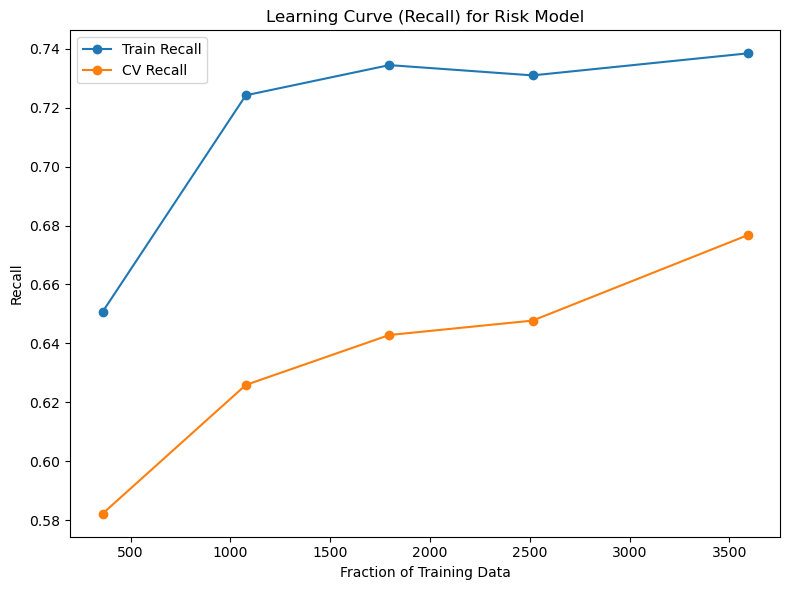

In [111]:
# 1. Load the trained XGBoost risk model
with open('../models/risk_XGBClassifier_train.pkl', 'rb') as file:
    optimized_model_train = pickle.load(file)

# 2. Compute learning curves on the TRAIN split
train_sizes, train_scores, cv_scores = learning_curve(
    optimized_model_train,
    X_train, y_train,
    cv=5,
    train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='recall',
    n_jobs=-1
)

# 3. Plot Train vs. CV Recall
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train Recall')
plt.plot(train_sizes, cv_scores.mean(axis=1), 'o-', label='CV Recall')
plt.title('Learning Curve (Recall) for Risk Model')
plt.xlabel('Fraction of Training Data')
plt.ylabel('Recall')
plt.legend()
plt.tight_layout()
plt.savefig(f"learning_curve.png")
plt.show()

## Detecting Non-Compliant Clients on the Full Population

To flag clients unlikely to fulfill contractual conditions, I:

1. **Load the chosen XGBoost model** (highest recall).  
2. **Score every client** with the model to get `risk_prob = P(non_compliant)`.  
3. **Apply a 0.5 cutoff** to classify each client as non-compliant or compliant.  
4. **Store the result** in `predicted_category`, with the labels **"Non-Compliant"** and **"Compliant"**.

### Business Metric for Risk Model

**Question:** Our PO is worried about the costs of offering our product to a customer that does not fulfill the contractual conditions. Which is the best metric to measure the quality of the results? What do you recommend?

**Answer:** In this scenario, the most costly mistake is classifying a high-risk (non-compliant) client as safe and therefore offering them the product. To minimize that, we focus on **recall** for the non-compliant class. By maximizing recall, we catch as many non-compliant clients as possible, reducing the number of defaults caused by missed high-risk cases.  

In [112]:
# Load the XGBoost model, selected because it outperformed RandomForest on recall, achieving 0.797 vs. 0.716 in cross-validation

with open('../models/risk_XGBClassifier_train.pkl', 'rb') as file:
    optimized_model_train = pickle.load(file)

In [113]:
# 1. Define your final selected features
selected_features = selected

# 2. Build the modeling DataFrame: features + target
df_risk_selected = training_df[selected_features + ['NON_COMPLIANT_CONTRACT','CLIENT_ID']]

# Save CLIENT_ID separately before dropping it
client_ids_all = df_risk_selected['CLIENT_ID']

# Prepare the feature set (X) and target variable (y)
y = df_risk_selected['NON_COMPLIANT_CONTRACT']
X = df_risk_selected.drop(['CLIENT_ID','NON_COMPLIANT_CONTRACT'], axis=1)

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (32899, 20), y shape: (32899,)


In [114]:
def segment_by_threshold(model, X, 
                         threshold=0.5, 
                         labels=('Class 0', 'Class 1'),
                         positive_class_index=1):
    """
    Generic segmentation for a binary classifier.

    Parameters
    ----------
    model : estimator
        A trained classifier with a `predict_proba` method.
    X : pd.DataFrame or array-like
        Feature matrix for the full population.
    threshold : float, default=0.5
        Probability cutoff for assigning the positive label.
    labels : tuple, length=2
        (negative_label, positive_label) to assign based on threshold.
    positive_class_index : int, default=1
        Index of the positive class in the array returned by predict_proba.

    Returns
    -------
    segments : pd.Series
        Assigned labels (labels[0] or labels[1]) for each row in X.
    probs : np.ndarray
        Predicted probabilities for the positive class.
    """
    # 1) Predict probabilities for the positive class
    probs = model.predict_proba(X)[:, positive_class_index]

    # 2) Assign segment labels based on threshold
    segments = pd.Series(
        np.where(probs >= threshold, labels[1], labels[0]),
        index=(X.index if hasattr(X, 'index') else None),
        name='segment'
    )

    return segments, probs


In [115]:
category, probs = segment_by_threshold(optimized_model_train, X, 
                                        threshold=0.5, 
                                        labels=('Non-Compliant','Compliant'))

In [116]:
output_table = raw_df
output_table['NonCompliance_prob'] = probs
output_table['predicted_category'] = category
output_table['actual'] = y.values

# Part 2: Product Propensity Modeling & Customer Segmentation

We build on the **same preprocessed dataset** used in Part 1 (clients with first transaction ≥ 2017, only their first six months of data, identical feature engineering, encoding and selection). The **only changes** are:

- **Target definition:** we now predict `product_2` (1 if the client contracted Product 2, else 0).  
- **Class balance:** we under-sample the majority class according to `product_2` after all preprocessing to ensure the model sees enough positive examples.

I’ll answer:  
1. **Who** is most likely to contract Product 1 vs. Product 2?  
2. **Which** features drive that choice?  
3. **Are there** natural customer segments with distinct product preferences?  


## Target Variable: `product_2`

Indicates whether a client ultimately **contracted Product 2** (vs. Product 1).  
- **Static per client:** one label for each client, regardless of transaction history length.  
- **Origin:** derived from the `NAME_PRODUCT_TYPE_PRODUCT 2` flag.  
- **Imbalance:** only **519** clients (1.58%) contracted Product 2 versus **32,380** clients (98.42%) who did not.  
- **Handling strategy:** the majority class will be under-sampled to create a balanced training set.  


In [117]:
df_propensity = training_df

# Renaming our new target variable
df_propensity.rename(
    columns={'NAME_PRODUCT_TYPE_PRODUCT 2': 'product_2'},
    inplace=True
)

# ensure it’s 0/1 integer
df_propensity['product_2'] = df_propensity['product_2'].astype(int)

Target Variable Distribution (Counts):
product_2
0    32380
1      519
Name: count, dtype: int64

Target Variable Distribution (Percentages):
product_2
0    98.42
1     1.58
Name: proportion, dtype: float64


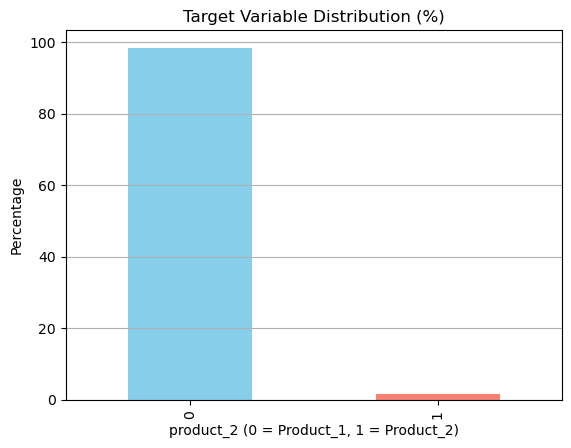

In [118]:
# Calculate the value counts and percentage
target_counts = df_propensity['product_2'].value_counts()
target_percentage = df_propensity['product_2'].value_counts(normalize=True) * 100

# Display
print("Target Variable Distribution (Counts):")
print(target_counts)
print("\nTarget Variable Distribution (Percentages):")
print(target_percentage.round(2))


target_percentage.plot(kind='bar', color=['skyblue', 'salmon'], title='Target Variable Distribution (%)')
plt.ylabel('Percentage')
plt.xlabel('product_2 (0 = Product_1, 1 = Product_2)')
plt.grid(axis='y')
plt.savefig(f"product_2.png")
plt.show()

## Undersample Majority Class  
To balance the target, I under-sampled the majority class (0) to match the minority class (1) at a 1:1 ratio.  

**Note:** With more time, I would explore alternative sampling strategies—such as SMOTE or hybrid under-/over-sampling—to increase the effective sample size while maintaining class balance.  


In [119]:
df_2 = df_propensity

In [120]:
# Separate the majority and minority classes
majority_class = df_2[df_2['product_2'] == 0]
minority_class = df_2[df_2['product_2'] == 1]

# Randomly sample the majority class to match the minority class size
majority_class_downsampled = majority_class.sample(n=minority_class.shape[0], random_state=42)

# Concatenate the downsampled majority class with the minority class
balanced_df2 = pd.concat([majority_class_downsampled, minority_class])

# Shuffle the final dataset to ensure randomness
balanced_df2 = balanced_df2.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the new class distribution
print(balanced_df2['product_2'].value_counts())

product_2
0    519
1    519
Name: count, dtype: int64


## Feature Selection with Random Forest

To reduce from ~179 features to a concise, high-value set for the propensity model, I applied the same procedure:

1. **Train a basic Random Forest** on `X_train, y_train` and extract its built-in `feature_importances_`.  
2. **Compute permutation importances** on the held-out split for a second ranking.  
3. **Select the top 50** from each ranking and **intersect** those lists to focus on consistently strong predictors.  
4. **Compute pairwise correlations** among the common features and flag any pairs with |corr| > 0.8.  
5. **For each correlated pair**, drop the feature with the lower permutation importance.  


In [121]:
df_2 = balanced_df2

# Save CLIENT_ID separately before dropping it
client_ids_2 = df_2['CLIENT_ID']
    
# Drop 'CLIENT_ID' as it's not used for model training
df_2 = df_2.drop(['CLIENT_ID','CURRENCY'], axis=1)

# Split the data into training and test sets
X, y, X_train, X_test, y_train, y_test = finance_train_test_split(df_2, target_column='product_2', test_size=0.3, random_state=123)

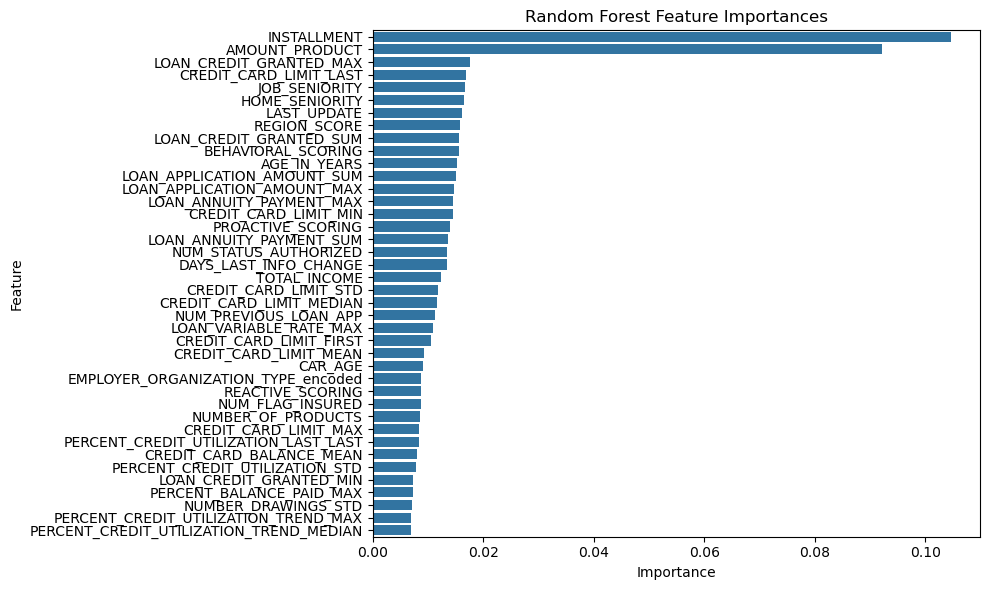

In [122]:
rf, feat_importances_df = get_rf_feature_importances(X_train, y_train, top_n=40)
feat_importances_df.to_csv('feat_importances_propensity.csv')

/tmp/ipykernel_47777/3858983005.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


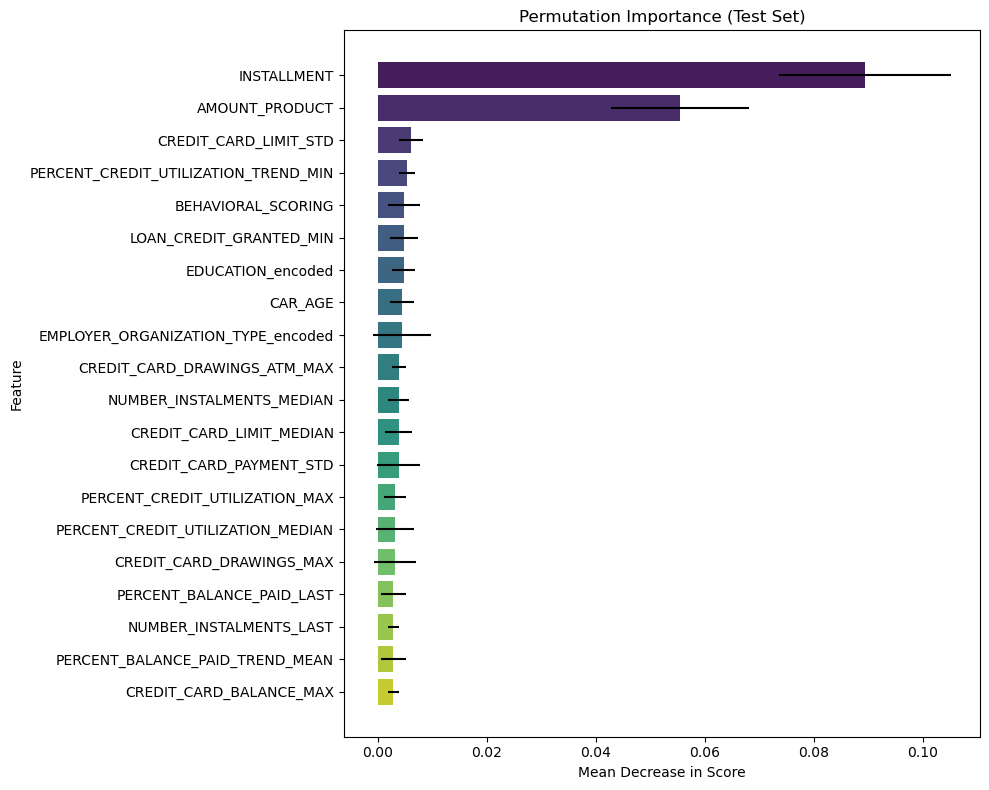

In [123]:
perm_importances_df = get_permutation_importances(rf, X_test, y_test, feature_names=X_train.columns, top_n=20)
perm_importances_df.to_csv('permutation_importance_propensity.csv')

In [124]:
selected, dropped, common = select_features(
    feat_importances_df,
    perm_importances_df,
    X_train,
    N=50,
    corr_threshold=0.8
)

Common features (top 50 RF ∩ top 50 Perm): ['CREDIT_CARD_LIMIT_LAST', 'INSTALLMENT', 'CREDIT_CARD_LIMIT_MAX', 'AGE_IN_YEARS', 'CREDIT_CARD_LIMIT_MEDIAN', 'LOAN_CREDIT_GRANTED_MIN', 'EMPLOYER_ORGANIZATION_TYPE_encoded', 'BEHAVIORAL_SCORING', 'LOAN_ANNUITY_PAYMENT_MAX', 'NUM_STATUS_ANNULLED', 'CREDIT_CARD_LIMIT_STD', 'NUMBER_OF_PRODUCTS', 'LOAN_CREDIT_GRANTED_MAX', 'AMOUNT_PRODUCT', 'CREDIT_CARD_BALANCE_MEAN', 'PERCENT_CREDIT_UTILIZATION_MAX', 'CREDIT_CARD_PAYMENT_MEAN', 'PERCENT_CREDIT_UTILIZATION_LAST', 'REACTIVE_SCORING', 'PERCENT_CREDIT_UTILIZATION_TREND_MEAN', 'CREDIT_CARD_PAYMENT_STD', 'CAR_AGE', 'NUM_STATUS_DENIED']

Highly correlated feature pairs (|corr| > 0.8):
  CREDIT_CARD_LIMIT_LAST & CREDIT_CARD_LIMIT_MAX: 0.88
  CREDIT_CARD_LIMIT_LAST & CREDIT_CARD_LIMIT_MEDIAN: 0.90
  INSTALLMENT & AMOUNT_PRODUCT: 0.80
  CREDIT_CARD_LIMIT_MAX & CREDIT_CARD_LIMIT_MEDIAN: 0.96
  CREDIT_CARD_PAYMENT_MEAN & CREDIT_CARD_PAYMENT_STD: 0.86

Features dropped due to high correlation:
{'CREDIT_CARD

In [125]:
selected

['INSTALLMENT',
 'AGE_IN_YEARS',
 'CREDIT_CARD_LIMIT_MEDIAN',
 'LOAN_CREDIT_GRANTED_MIN',
 'EMPLOYER_ORGANIZATION_TYPE_encoded',
 'BEHAVIORAL_SCORING',
 'LOAN_ANNUITY_PAYMENT_MAX',
 'NUM_STATUS_ANNULLED',
 'CREDIT_CARD_LIMIT_STD',
 'NUMBER_OF_PRODUCTS',
 'LOAN_CREDIT_GRANTED_MAX',
 'CREDIT_CARD_BALANCE_MEAN',
 'PERCENT_CREDIT_UTILIZATION_MAX',
 'PERCENT_CREDIT_UTILIZATION_LAST',
 'REACTIVE_SCORING',
 'PERCENT_CREDIT_UTILIZATION_TREND_MEAN',
 'CREDIT_CARD_PAYMENT_STD',
 'CAR_AGE',
 'NUM_STATUS_DENIED']

## Training & Model Selection for Product Propensity

In this stage, I use the final 19 features and the `product_2` target:

1. **Hyperparameter Optimization**  
   - For each candidate model (e.g. RandomForest, XGBoost) I run a grid/random search over its parameter grid.  
   - The best estimator is saved (or loaded if already computed) to avoid retraining.

2. **Performance Assessment**  
   - On the **training split**, I compute cross‐validated accuracy, precision and **recall** for the positive class (`product_2 = 1`) to ensure the model learns to identify Product 2 takers.  
   - On the **test split**, I compute accuracy, precision, recall and F1 to measure real‐world performance.

3. **Results Summary**  
   - All metrics are collected into a single DataFrame for easy comparison.  
   - Since our goal is to find as many Product 2 customers as possible, we select the model with the **highest recall** on the positive class.

4. **Feature Report**  
   - After choosing the best model, a feature‐importance report is generated to confirm that our 19 selected predictors are driving the propensity scores.

This pipeline ensures we thoroughly tune, validate and choose the model that best identifies customers likely to contract Product 2.  


In [126]:
# 1. Define your final selected features
selected_features = selected

# 2. Build the modeling DataFrame: features + target
df_model = df_2[selected_features + ['product_2']]

# 3. Split into train/test
X, y, X_train, X_test, y_train, y_test = finance_train_test_split(
    df_model,
    target_column='product_2',
    test_size=0.3,
    random_state=123
)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Training set shape: (726, 19), Test set shape: (312, 19)


In [127]:
chosen_models = [(RandomForestClassifier, rf_random_grid, False),\
                (xgb.XGBClassifier, xgb_param_grid, False)]

reports_for_all_models = run_pipeline_for_all_models(df_model, 'product_2', chosen_models, '../models/propensity', regenerate_model=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Finished doing grid search for RandomForestClassifier
Finished generating train model fit on X_train and y_train
Mean cross-validation score (accuracy) of best estimator:
0.7737480438184663
Best params:
{'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': False}
Finished generating final model fit on the full dataset
finished saving final models for RandomForestClassifier Sale
generated optimized model
Accuracy: 0.738 (+/- 0.097)
finished calculating cv score accuracy
Accuracy: 0.775 (+/- 0.120)
finished calculating cv score precision
Accuracy: 0.740 (+/- 0.109)
finished calculating cv score recall
finished calculating test error
Generated performance metrics for test
Finished calculating train and test error for RandomForestClassifier
X_train: 19: columns
RandomForestClassifier(bootstrap=False, c

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Finished doing grid search for XGBClassifier
Finished generating train model fit on X_train and y_train
Mean cross-validation score (accuracy) of best estimator:
0.8295383411580595
Best params:
{'subsample': 1.0, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Finished generating final model fit on the full dataset
finished saving final models for XGBClassifier Sale
generated optimized model
Accuracy: 0.808 (+/- 0.046)
finished calculating cv score accuracy
Accuracy: 0.822 (+/- 0.094)
finished calculating cv score precision
Accuracy: 0.808 (+/- 0.046)
finished calculating cv score recall
finished calculating test error
Generated performance metrics for test
Finished calculating train and test error for XGBClassifier
X_train: 19: columns
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_byt

In [128]:
reports_for_all_models

[                    model     target  train cv_accuracy train cv_precision  \
 0  RandomForestClassifier  product_2  0.738 (+/- 0.097)  0.775 (+/- 0.120)   
 
      train cv_recall  test accuracy  test precision  test recall  
 0  0.740 (+/- 0.109)       0.798077        0.798063     0.798077  ,
            model     target  train cv_accuracy train cv_precision  \
 0  XGBClassifier  product_2  0.808 (+/- 0.046)  0.822 (+/- 0.094)   
 
      train cv_recall  test accuracy  test precision  test recall  
 0  0.808 (+/- 0.046)       0.846154        0.846255     0.846154  ]

## Determining Offers for the Full Population

To decide which clients should be offered each product, I:

1. **Load the chosen XGBoost propensity model** (highest recall for Product 2).  
2. **Score every client** with the model to get `P2 = P(product_2)`.  
3. **Apply a 0.5 cutoff** to assign each client:  
   - `P2 ≥ 0.5` → **offer Product 2**  
   - `P2 <  0.5` → **offer Product 1**  
4. **Store the result** in `predicted_offer`, with labels **"Product 2"** and **"Product 1"**.  
5. **Summarize** the counts for each offer group:  
   - **Product 2:** 29,646 clients  
   - **Product 1:**  3,253 clients  

This yields a clear, data-driven rule: clients with high predicted propensity get Product 2 offers, the rest get Product 1.  


In [129]:
# Load the XGBoost model, selected because it outperformed RandomForest on recall, achieving 0.797 vs. 0.716 in cross-validation

with open('../models/propensity_XGBClassifier_train.pkl', 'rb') as file:
    optimized_model_train = pickle.load(file)

In [130]:
# 1. Define your final selected features
selected_features = selected

# 2. Build the modeling DataFrame: features + target
df_propensity_selected = df_propensity[selected_features + ['product_2','CLIENT_ID']]

# Save CLIENT_ID separately before dropping it
client_ids_all = df_propensity_selected['CLIENT_ID']

# Prepare the feature set (X) and target variable (y)
y = df_propensity_selected['product_2']
X = df_propensity_selected.drop(['CLIENT_ID','product_2'], axis=1)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (32899, 19), y shape: (32899,)


In [131]:
df_propensity_selected.head()

,INSTALLMENT,AGE_IN_YEARS,CREDIT_CARD_LIMIT_MEDIAN,LOAN_CREDIT_GRANTED_MIN,EMPLOYER_ORGANIZATION_TYPE_encoded,BEHAVIORAL_SCORING,LOAN_ANNUITY_PAYMENT_MAX,NUM_STATUS_ANNULLED,CREDIT_CARD_LIMIT_STD,NUMBER_OF_PRODUCTS,LOAN_CREDIT_GRANTED_MAX,CREDIT_CARD_BALANCE_MEAN,PERCENT_CREDIT_UTILIZATION_MAX,PERCENT_CREDIT_UTILIZATION_LAST,REACTIVE_SCORING,PERCENT_CREDIT_UTILIZATION_TREND_MEAN,CREDIT_CARD_PAYMENT_STD,CAR_AGE,NUM_STATUS_DENIED,product_2,CLIENT_ID
0,298.24,34.320548,540.0,352.84,26,0.524496,132.49,0.0,577.284283,1.0,731.70,0.000,0.000000,0.000000,0.495917,0.000000,0.000000,9.0,0.0,0,ES182154395P
1,455.38,40.219178,1620.0,0.00,1,0.670652,81.00,3.0,0.000000,3.0,1693.71,0.000,0.000000,0.000000,0.781124,0.000000,43.926546,9.0,0.0,0,ES182400170J
2,619.87,46.410959,2700.0,0.00,0,0.508287,379.50,2.0,0.000000,3.0,15012.00,628.625,39.454074,21.348889,0.495917,-5.187037,495.604057,9.0,0.0,0,ES182189427K
3,204.93,42.578082,8100.0,0.00,12,0.689479,405.00,3.0,0.000000,2.0,8100.00,208.700,18.035802,18.035802,0.495917,18.035802,0.000000,9.0,3.0,0,ES182212741F
4,248.35,38.005479,5400.0,0.00,0,0.508287,270.00,5.0,0.000000,3.0,5400.00,0.000,0.000000,0.000000,0.495917,0.000000,0.000000,6.0,0.0,0,ES182191583N


In [132]:
offers, probs = segment_by_threshold(optimized_model_train, X, 
                                        threshold=0.5, 
                                        labels=('Product 2', 'Product 1'))

In [133]:
output_table_2 = raw_df
output_table_2['P2'] = probs
output_table_2['predicted_offer'] = offers
output_table_2['actual'] = y.values

In [134]:
output_table_2['predicted_offer'].value_counts() # Offer Product 2 to those 5943 clients; Product 1 to the rest.

predicted_offer
Product 2    27076
Product 1     5823
Name: count, dtype: int64

## Approaches to Identify Customers Most Likely to Contract Each Product

_To answer: **Can you identify which customers are more likely to contract Product 1 vs. Product 2?**_

1. **Decile-Based Slicing**  
   - Select the **bottom 10%** of clients by predicted \(P_2\) as the strongest Product 1 prospects and the **top 10%** as the strongest Product 2 prospects.  
   - Ideal for a focused outreach list of “sure bets” at both extremes.

2. **Three-Band Segmentation**  
   - Bin \(P2\) into **Low (< 0.3)**, **Intermediate (0.3 – 0.6)**, and **High (> 0.6)** groups.  
   - **High** → offer Product 2; **Low** → offer Product 1; **Intermediate** → target with special promotions.

**Next:** implement both methods on the full population and compare which customers fall into each segment.  


In [135]:
output_table_2 = output_table_2.sort_values('P2', ascending=False)

#The top rows (highest P2) are the most likely Product 2 takers.
#The bottom rows (lowest 'predicted') are the most likely Product 1 takers (since P1=1−P2).

In [136]:
# top_decile is the 10% of customers with the highest P2.

thresh_90 = output_table_2['P2'].quantile(0.90)
top_decile = output_table_2[output_table_2['P2'] >= thresh_90]

In [137]:
# bottom_decile is the 10% of customers most likely to take P1.

thresh_10 = output_table_2['P2'].quantile(0.10)
bottom_decile = output_table_2[output_table_2['P2'] <= thresh_10]

In [148]:
selected_features= [['INSTALLMENT',
 'AGE_IN_YEARS',
 'CREDIT_CARD_LIMIT_MEDIAN',
 'LOAN_CREDIT_GRANTED_MIN',
 'EMPLOYER_ORGANIZATION_TYPE',
 'BEHAVIORAL_SCORING',
 'LOAN_ANNUITY_PAYMENT_MAX',
 'NUM_STATUS_ANNULLED',
 'CREDIT_CARD_LIMIT_STD',
 'NUMBER_OF_PRODUCTS',
 'LOAN_CREDIT_GRANTED_MAX',
 'CREDIT_CARD_BALANCE_MEAN',
 'PERCENT_CREDIT_UTILIZATION_MAX',
 'PERCENT_CREDIT_UTILIZATION_LAST',
 'REACTIVE_SCORING',
 'PERCENT_CREDIT_UTILIZATION_TREND_MEAN',
 'CREDIT_CARD_PAYMENT_STD',
 'CAR_AGE',
 'NUM_STATUS_DENIED']]

In [149]:
# 1) Define segments based on P2
thresholds = {'low': 0.3, 'high': 0.6}
output_table_2['segment'] = pd.cut(
    output_table_2['P2'],
    bins=[0, thresholds['low'], thresholds['high'], 1],
    labels=['Low (<0.3)', 'Intermediate (0.3–0.6)', 'High (>0.6)'],
    include_lowest=True
)

In [150]:
# 2) Compute segment sizes and percentages
segment_counts = output_table_2['segment'].value_counts().sort_index()
segment_pct    = (segment_counts / len(output_table_2) * 100).round(2)
print("Segment distribution (%):")
print(segment_pct.to_frame(name='Percent'))

Segment distribution (%):
                        Percent
segment                        
Low (<0.3)                72.57
Intermediate (0.3–0.6)    13.32
High (>0.6)               14.11


In [141]:
# Extract categorical features via select_dtypes
cat_features = [
    col for col in selected_features
    if col in output_table_2.select_dtypes(include=['object', 'category']).columns
]

# Extract numeric features via select_dtypes
num_features = [
    col for col in selected_features
    if col in output_table_2.select_dtypes(include=['number']).columns
]

print("Categorical features:", cat_features)
print("Numeric features:    ", num_features)


Categorical features: ['EMPLOYER_ORGANIZATION_TYPE']
Numeric features:     ['DAYS_LAST_INFO_CHANGE', 'PERCENT_BALANCE_PAID_STD', 'PERCENT_CREDIT_UTILIZATION_LAST_MAX', 'INSTALLMENT', 'PROACTIVE_SCORING', 'CREDIT_CARD_LIMIT_MAX', 'BEHAVIORAL_SCORING', 'NUMBER_OF_PRODUCTS', 'LOAN_VARIABLE_RATE_MAX', 'REGION_SCORE', 'CREDIT_CARD_BALANCE_MAX', 'REACTIVE_SCORING', 'CREDIT_CARD_PAYMENT_MEAN', 'LOAN_APPLICATION_AMOUNT_MAX', 'NUMBER_DRAWINGS_STD', 'LOAN_ANNUITY_PAYMENT_SUM', 'CREDIT_CARD_LIMIT_STD', 'PERCENT_CREDIT_UTILIZATION_TREND_FIRST']


In [142]:
# 3) Compute mode for categorical features by segment
cat_mode = output_table_2.groupby('segment')[cat_features] \
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)

# 4) Compute mean & median for numeric features by segment
num_stats = output_table_2.groupby('segment')[num_features] \
    .agg(['mean', 'median']).round(2)

# 5) Flatten numeric MultiIndex columns
num_stats.columns = ['_'.join(col) for col in num_stats.columns]

# 6) Combine into one DataFrame
stats_df = pd.concat([cat_mode, num_stats], axis=1)


/tmp/ipykernel_47777/45781823.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cat_mode = output_table_2.groupby('segment')[cat_features] \
/tmp/ipykernel_47777/45781823.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_stats = output_table_2.groupby('segment')[num_features] \


In [143]:
stats_df

,EMPLOYER_ORGANIZATION_TYPE,DAYS_LAST_INFO_CHANGE_mean,DAYS_LAST_INFO_CHANGE_median,PERCENT_BALANCE_PAID_STD_mean,PERCENT_BALANCE_PAID_STD_median,PERCENT_CREDIT_UTILIZATION_LAST_MAX_mean,PERCENT_CREDIT_UTILIZATION_LAST_MAX_median,INSTALLMENT_mean,INSTALLMENT_median,PROACTIVE_SCORING_mean,PROACTIVE_SCORING_median,CREDIT_CARD_LIMIT_MAX_mean,CREDIT_CARD_LIMIT_MAX_median,BEHAVIORAL_SCORING_mean,BEHAVIORAL_SCORING_median,NUMBER_OF_PRODUCTS_mean,NUMBER_OF_PRODUCTS_median,LOAN_VARIABLE_RATE_MAX_mean,LOAN_VARIABLE_RATE_MAX_median,REGION_SCORE_mean,REGION_SCORE_median,CREDIT_CARD_BALANCE_MAX_mean,CREDIT_CARD_BALANCE_MAX_median,REACTIVE_SCORING_mean,REACTIVE_SCORING_median,CREDIT_CARD_PAYMENT_MEAN_mean,CREDIT_CARD_PAYMENT_MEAN_median,LOAN_APPLICATION_AMOUNT_MAX_mean,LOAN_APPLICATION_AMOUNT_MAX_median,NUMBER_DRAWINGS_STD_mean,NUMBER_DRAWINGS_STD_median,LOAN_ANNUITY_PAYMENT_SUM_mean,LOAN_ANNUITY_PAYMENT_SUM_median,CREDIT_CARD_LIMIT_STD_mean,CREDIT_CARD_LIMIT_STD_median,PERCENT_CREDIT_UTILIZATION_TREND_FIRST_mean,PERCENT_CREDIT_UTILIZATION_TREND_FIRST_median
segment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Low (<0.3),0001,970.56,805.0,2911.79,2.25,36.14,0.72,354.02,320.92,0.51,0.56,3065.53,2430.0,0.50,0.51,2.84,3.0,0.12,0.1,0.02,0.02,1310.59,537.91,0.49,0.5,140.38,46.29,5337.90,3240.0,2.41,0.79,951.30,684.71,147.70,0.0,20.97,0.0
Intermediate (0.3–0.6),0001,1060.61,993.0,3163.76,2.25,30.69,0.00,276.68,243.54,0.52,0.57,4212.37,3240.0,0.47,0.51,3.35,3.0,0.12,0.1,0.02,0.02,1663.68,551.88,0.51,0.5,187.10,61.70,7757.28,5940.0,2.37,0.79,1310.27,1003.96,217.51,0.0,16.79,0.0
High (>0.6),0001,1053.37,954.0,9018.02,2.07,24.64,0.00,202.67,149.74,0.51,0.56,4035.62,2700.0,0.47,0.51,3.46,3.0,0.12,0.1,0.02,0.02,1536.09,320.24,0.51,0.5,188.89,59.79,7074.73,5400.0,2.23,0.79,1196.99,893.19,296.01,0.0,11.08,0.0


## Detecting an “Interesting” Customer Segment

Splitting clients by P₂ into Low (<0.3), Intermediate (0.3–0.6) and High (>0.6) reveals:

| Metric                                       | Low (<0.3)        | Intermediate (0.3–0.6) | High (>0.6)       |
|----------------------------------------------|------------------:|-----------------------:|------------------:|
| Proactive scoring (mean/median)              | 0.51 / 0.56       | **0.52 / 0.57**         | 0.51 / 0.56       |
| Installment amount (mean/median)             | 354.02 / 320.92   | **276.68 / 243.54**     | 202.67 / 149.74   |
| Max credit utilization % (mean/median)       | 36.14 / 0.72      | **30.69 / 0.00**        | 24.64 / 0.00      |
| Number of products held (mean/median)        | 2.84 / 3.0        | **3.35 / 3.0**          | 3.46 / 3.0        |

**Why the Intermediate band is interesting:**  
- **Highest proactive engagement** (top scoring) – most receptive to outreach.  
- **Moderate installment levels** → they have spending capacity left.  
- **Balanced credit usage** → room to upsell without overextension.  
- **Solid product mix** (more products than Low) but not yet saturated like High.  

This mid-propensity cohort combines engagement and capacity, ideal targets for tailored offers to move them into the High-propensity bracket.



## Part 3: Disparate Impact Analysis (4/5-Rule)

**Question:**  
Are certain demographic groups systematically disadvantaged by our models?

**Approach:**  
1. **Selection Rate**  
   - **Risk model:** fraction of each group labeled “Non-Compliant”  
   - **Propensity model:** fraction of each group offered Product 2  

2. **Disparate Impact (DI)**  
   $$\mathrm{DI} = \frac{\displaystyle \text{Selection Rate}_{\text{group}}}{\displaystyle \text{Selection Rate}_{\text{reference}}}$$  
   - Reference = group with the highest selection rate  
   - DI < 0.8 or DI > 1.25 → potential unfair bias (4/5-Rule)  

3. **Protected attributes:**  
   GENDER, AGE_GROUP, EDUCATION, MARITAL_STATUS, HOME_SITUATION, REGION_SCORE  

---

### Gender

| Model       | Group | Sel. Rate | Reference |  DI  |
|:------------|------:|----------:|----------:|-----:|
| Risk        | F     | 0.66      | F         | 1.00 |
| Risk        | M     | 0.59      | F         | 0.88 |
| Propensity  | F     | 0.81      | M         | 0.96 |
| Propensity  | M     | 0.84      | M         | 1.00 |

---

### Marital Status

| Model       | Group   | Sel. Rate | Reference |  DI  |
|:------------|--------:|----------:|----------:|-----:|
| Risk        | Married | 0.64      | Married   | 1.00 |
| Risk        | Single  | 0.63      | Married   | 0.98 |
| Propensity  | Married | 0.83      | Married   | 1.00 |
| Propensity  | Single  | 0.80      | Married   | 0.96 |

**Interpretation:**  
All DI values fall within [0.8 – 1.25], indicating no significant unfair bias for these attributes.  
Extend this audit to other protected groups (e.g., age bands) and monitor DI over time (especially pre- vs. post-pandemic).


In [144]:
# As illustration we will consider gender and marital status
protected_attrs = ['GENDER', 'MARITAL_STATUS'] 

In [145]:
# Map “Non-Compliant” → 1, “Compliant” → 0
risk_map = {'Non-Compliant': 1, 'Compliant': 0}
output_table['predicted_category_bin'] = output_table['predicted_category'].map(risk_map)

# Map “Product 2” → 1, “Product 1” → 0
prop_map = {'Product 2': 1, 'Product 1': 0}
output_table_2['predicted_offer_bin'] = output_table_2['predicted_offer'].map(prop_map)


In [146]:
def compute_di(df, decision_col, group_col):
    
    # 1) Compute each group’s selection rate
    rates = df.groupby(group_col)[decision_col].mean()
    
    # 2) Pick the reference group (the one with the highest rate)
    ref_group = rates.idxmax()
    ref_rate  = rates.loc[ref_group]
    
    # 3) Compute DI ratios
    di = rates / ref_rate
    
    return pd.DataFrame({
        'selection_rate': rates,
        'reference': ref_group,
        'DI': di
    })


In [147]:
# Run the audit for both models
for attr in protected_attrs:
    print(f"\n=== Disparate Impact for {attr} ===")
    
    # Risk model audit
    print("\nRisk Model (high_risk):")
    di_risk = compute_di(output_table, 'predicted_category_bin', attr)
    print(di_risk.round(2))
    
    # Propensity model audit
    print("\nPropensity Model (offer_P2):")
    di_prop = compute_di(output_table_2, 'predicted_offer_bin', attr)
    print(di_prop.round(2))


=== Disparate Impact for GENDER ===

Risk Model (high_risk):
        selection_rate reference    DI
GENDER                                
F                 0.66         F  1.00
M                 0.59         F  0.88

Propensity Model (offer_P2):
        selection_rate reference    DI
GENDER                                
F                 0.81         M  0.96
M                 0.84         M  1.00

=== Disparate Impact for MARITAL_STATUS ===

Risk Model (high_risk):
                selection_rate reference    DI
MARITAL_STATUS                                
Married                   0.64   Married  1.00
Single                    0.63   Married  0.98

Propensity Model (offer_P2):
                selection_rate reference    DI
MARITAL_STATUS                                
Married                   0.83   Married  1.00
Single                    0.80   Married  0.96


## Part 4: Checking for Changing Conditions with Out-of-Time Testing

**Not coded due to time constraints:**  
 If I had more time, I would fully implement the steps below in code to validate and monitor drift.

**Question:**  
Economic shifts and changing consumer habits can alter data distributions and degrade model performance. How can I guard against this?

**Answer:**  
1. **Out-of-Time (OOT) Split**  
   - Use **2013–2016** as an OOT test set and train on **2017–2022**.  
   - Apply the **same cleaning and feature pipeline** to both periods.

2. **Model Scoring**  
   - Score the OOT set with both the risk and propensity models.

3. **Performance Comparison**  
   - Compute **AUC**, **recall** and **precision** on OOT predictions.  
   - Compare to 2017–2022 metrics—large drops signal drift.

4. **Feature Drift Check with PSI**  
   - Select a handful of key features (or predicted probabilities).  
   - Bin values identically in both periods and calculate the **Population Stability Index (PSI)**.  
   - A **PSI > 0.25** indicates a significant shift in that feature’s distribution.

5. **Next Steps**  
   - If performance falls or PSI exceeds thresholds, schedule a **retraining** or implement **continuous drift monitoring** to keep the model accurate over time.  
